In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils
import config
try:
    import seaborn as sns
except ModuleNotFoundError: 
    !conda install seaborn --yes
    import seaborn as sns
from sklearn import metrics
from scipy.stats import pearsonr
import mine_emis

from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# Run this periodically to get new EPA data
# utils.get_all_FF_tables()

In [2]:
T_TO_M_T = utils.T_TO_M_T
M_T_TO_T = utils.M_T_TO_T
M3_TO_KG = utils.M3_TO_KG
KG_TO_M_T = utils.KG_TO_M_T # kg to million metric tons 

In [ ]:
START_YEAR = 2022
END_YEAR = 2022 # EPA GHGRP only goes up to 2022 for now
EMISSIONS_PER_DAY = "../data/kelly_plumes_20250211/radial_MAD_alpha/emissions_per_day.csv" #"../data/kelly_plumes_20241018/qc_emissions_per_day.csv"
INVENTORY_FILE = "../data/Inventory_emissions.csv"
VENT_FILE = '../data/labeled_vents.kml'
LOOKUP_TABLE = '../data/facility_lookup.csv'
FF_TABLES = config.FF_TABLES

basin_names_replacement = {
    'Central Appalachian Basin': 'central Appalachian Basin',
    'Illinois Basin': 'Illinois Basin',
    'North Great Plains Basin': 'Northern Great Plains',
    'Northern Appalachian Basin': 'northern Appalachian Basin',
    'Southwest and Rockies Basin': 'Colorado Plateau',
    'Warrior Basin': 'Black Warrior Basin',}

mine_names_replacement = {


In [4]:
# TODO: what to do with mines not in CoalAge Database?

In [5]:
vents = utils.read_infrastructure_file(VENT_FILE)

lut = pd.read_csv(LOOKUP_TABLE)[['facility_id', 
                                          'facility_name', 
                                          'msha_identification_number', 
                                          'facility_name_state']]
lut['facility_id'] = lut['facility_id'].astype(str).str.replace('.0', '', regex=False)
lut['msha_identification_number'] = lut['msha_identification_number'].astype(str).str.replace('.0', '', regex=False)

inventory = pd.read_csv(INVENTORY_FILE)
inventory = inventory[inventory['MINE_ID'].notnull()]  # null MSHA ID means mine never opened
inventory['MINE_ID'] = inventory['MINE_ID'].astype(str).str.replace('.0','', regex=False)

# gap fill IPCC & Kholod with GEMs mine values
inventory.loc[inventory['Kholod_emis_CoalAge_M_T'].isnull(),'Kholod_emis_CoalAge_M_T'] = inventory['Kholod_emis_M_T'] 
inventory.loc[inventory['IPCC_emis_CoalAge_M_T'].isnull(),'IPCC_emis_CoalAge_M_T'] = inventory['IPCC_emis_M_T'] 

inventory = inventory[(inventory['CAL_YR'] >= START_YEAR) & (inventory['CAL_YR'] <= END_YEAR)]
inventory['GAS_CONTENT (T/T)'] = inventory['Underground Average In Situ Content (ft3/short ton)']\
        * utils.FT3_PER_SHORT_TON_TO_M3_PER_TON * utils.M3_TO_KG * utils.KG_TO_MT # convert to metric tons

inventory = pd.merge(inventory, lut[['msha_identification_number', 'facility_id']], 
                     left_on='MINE_ID', right_on='msha_identification_number', how='left')

In [6]:
epa_emis = mine_emis.ghgrp()
epa_emis[['tot_qrtly_ch4', 
          'qtr_fac_total_qrtly_netch4emis',
          'qtr_meth_liber_vent_calc',
          'net_well_emis']
                ] = epa_emis[['tot_qrtly_ch4', 
                              'qtr_fac_total_qrtly_netch4emis',
                              'qtr_meth_liber_vent_calc',
                              'net_well_emis']] * T_TO_M_T
epa_emis = epa_emis.rename(columns={'tot_qrtly_ch4': 'epa_true_M_T', 
                                    'qtr_fac_total_qrtly_netch4emis': 'epa_net_emis_M_T',
                                    'qtr_meth_liber_vent_calc' : 'epa_vent_true_M_T',
                                    'net_well_emis' : 'epa_degas_true_M_T'})

emission_comparison = pd.merge(inventory, epa_emis, 
                               left_on=('facility_id', 'CAL_YR', 'CAL_QTR'), 
                               right_on=('facility_id','reporting_year', 'quarter'), 
                               how='left')

emission_comparison[['epa_true_T',
                     'epa_vent_true_T',
                     'epa_degas_true_T', 
                     'epa_net_emis_T', 
                     'GEM_emis_T', 
                     'Kholod_emis_T', 
                     'IPCC_emis_T',
                     'Basin_emis_T',
                     'EPA_emis_T',
                     'CM_vent_emis_T',
                     'CM_min_emis_T',
                     'CM_max_emis_T',
                     'CM_well_emis_T',
                     'CM_well_min_emis_T',
                     'CM_well_max_emis_T']] = M_T_TO_T * emission_comparison[['epa_true_M_T', 
                                                                         'epa_vent_true_M_T',
                                                                         'epa_degas_true_M_T',
                                                                        'epa_net_emis_M_T', 
                                                                        'GEM_emis_CoalAge_M_T', 
                                                                        'Kholod_emis_CoalAge_M_T', 
                                                                        'IPCC_emis_CoalAge_M_T', 
                                                                        'Basin_emis_M_T',
                                                                        'EPA_emis_M_T',
                                                                        'CM_vent_emis_M_T',
                                                                        'CM_min_emis_M_T',
                                                                        'CM_max_emis_M_T',
                                                                        'CM_well_emis_M_T',
                                                                        'CM_well_min_emis_M_T',
                                                                        'CM_well_max_emis_M_T',
                                                                        ]]

Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: OAK GROVE MINE
Fixing number of shafts in: BAILEY MINE-CRABAPPLE PORTAL
Fixing number of shafts in: ENLOW FORK MINE
Fixing number of shafts in: HARVEY MINE
Fixing number of shafts in: HARRISON COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARION COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MARSHALL COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: MONONGALIA COUNTY MINE
Fixing number of shafts in: LEER SOUTH MINING COMPLEX


In [7]:
inventory.groupby('MINE_ID')['Coal Type'].unique().value_counts()

[Bituminous]    303
[Anthracite]      7
Name: Coal Type, dtype: int64

In [8]:
cm_detected_emis = mine_emis.carbonmapper(emissions_per_day_file=EMISSIONS_PER_DAY, 
                                          lookup_table_file=LOOKUP_TABLE, 
                                          vent_file=VENT_FILE)
cm_detected_emis = pd.merge(cm_detected_emis, lut, on='facility_id', how='left')

emission_comparison = pd.merge(emission_comparison, cm_detected_emis[
       ['facility_id', 'year', 'quarter',
       'vent_emission_auto', 'well_emission_auto',
       'vent_emission_uncertainty_auto', 'well_emission_uncertainty_auto',
       'vent_observed', 'well_observed', 'vent_vent_id', 'well_vent_id',
       'total_emission_auto', 'total_vent_id', 'total_observed',
       'total_emission_uncertainty_auto']], 
       right_on=["facility_id","year","quarter"], 
       left_on=['facility_id', 'CAL_YR', 'CAL_QTR'], 
       how="left")

emission_comparison[['vent_emission_auto', 
                     'well_emission_auto',
                     'vent_emission_uncertainty_auto', 
                     'well_emission_uncertainty_auto',
                     'total_emission_auto', 
                     'total_emission_uncertainty_auto']] = (1/utils.MT_QRT_TO_KG_HR) * emission_comparison[
                         ['vent_emission_auto', 
                          'well_emission_auto',
                          'vent_emission_uncertainty_auto', 
                          'well_emission_uncertainty_auto',
                          'total_emission_auto', 
                          'total_emission_uncertainty_auto']]

emission_comparison['CM_vent_plus_well_emis_T'] = emission_comparison['CM_well_emis_T'].fillna(0.) + emission_comparison['CM_vent_emis_T']

In [9]:
no_epa = emission_comparison['epa_true_T'].isnull()
emission_comparison.loc[no_epa,"MINE_ID"].nunique()

250

In [10]:
no_epa = emission_comparison['facility_id'].isnull()
emission_comparison.loc[no_epa,"MINE_ID"].nunique()

241

In [11]:
emission_comparison.loc[emission_comparison['CAL_YR']==2019,'epa_true_T'].sum()

0.0

In [12]:
# EPA estimate 2019: 1,370,300

In [13]:
# find if a mine has wells
# change dot. 

In [62]:
def color_scatter(INVENTORY, TITLE, COLORS, figure_letter='', ax=None, 
                  xlim=(-600,50000), ylim=(-600,50000), year=2022, 
                  df_in=emission_comparison, ycol='epa_true_T', order=None, 
                  UNIT_CONVERSION = 1, EPA_TOTAL=None, cmap = plt.get_cmap('tab10'),
                  separate_gob_wells=True, decimals_total=1, plot_slope=False):
    xlim, ylim = np.array(xlim) * UNIT_CONVERSION, np.array(ylim) * UNIT_CONVERSION
    if ax is None: 
        fig, ax = plt.subplots(dpi=200)
    metrics_df = pd.DataFrame(columns=['State', 'Mean Percent Bias', 'Mean Bias', 'RMSPE', 
                                       'inventory total (Tg)', 'EPA total (Tg)', 'bias of total (%)', 
                                       'emission factor'])
    
    df = df_in[df_in.CAL_YR==year].copy()
    df['reports_to_epa'] = ~df[ycol].isnull()
    df.loc[~df.reports_to_epa,ycol] = 0.
    i = 0
    groups = df[COLORS].unique() if order is None else df[COLORS].unique()[order]
    if separate_gob_wells:
        has_gob_wells = df['epa_degas_true_T'] > 0
    else:
        has_gob_wells = np.full(df.shape[0], False)
    for item in groups:
        mask = df[COLORS] == item
        mean_percent_bias = 100 * (df[INVENTORY][mask] - 
                                   df[ycol][mask]).mean() / df[ycol][mask].mean()
        rmspe = np.sqrt(np.mean((df[INVENTORY][mask] - 
                                 df[ycol][mask]) ** 2) / df[ycol][mask].mean())
        mean_bias = (df[INVENTORY][mask] - df[ycol][mask]).mean()
        inventory_total = df[INVENTORY][mask].sum()
        epa_total = df[ycol][mask].sum()
        bias_of_total = (inventory_total - epa_total) / epa_total * 100
        metrics_df = metrics_df._append({'State': item, 
                                         'Mean Percent Bias': mean_percent_bias, 
                                         'Mean Bias': mean_bias, 
                                         'RMSPE': rmspe, 
                                         'inventory total (Tg)': inventory_total / 1e6,
                                         'EPA total (Tg)': epa_total / 1e6, 
                                         'bias of total (%)': bias_of_total}, 
                                         ignore_index=True)
        
        label = basin_names_replacement[item] if item in basin_names_replacement else item
        ax.scatter(df[ycol][(mask)&(df.reports_to_epa)] * UNIT_CONVERSION, 
                   df[INVENTORY][(mask)&(df.reports_to_epa)] * UNIT_CONVERSION,
                   label=label, facecolor=cmap(i), edgecolor='none', alpha=0.75, zorder=-1, marker="o", s=35)
        ax.scatter(df[ycol][(mask)&(df.reports_to_epa)&(has_gob_wells)] * UNIT_CONVERSION, 
                   df[INVENTORY][(mask)&(df.reports_to_epa)&(has_gob_wells)] * UNIT_CONVERSION,
                   c='yellow', zorder=-1, marker=".", s=10)
        ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION, 
                   df[INVENTORY][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION, 
                   c=cmap(i), marker='_')
        i += 1

    # plot RMA
    slope, intercept, r = utils.rma_regression(df[ycol],  df[INVENTORY]) 
    intercept = intercept * UNIT_CONVERSION
    print(INVENTORY)
    print(f"slope: {slope}")
    ax.plot([0, xlim[1]],
            [intercept, xlim[1] * slope + intercept], 
            color='k', 
            linestyle="--", 
            label="RMA regression")
    # plot 1:1
    ax.plot(xlim, ylim, color='k', label="1:1")
    if ax is None:
        ax.set_ylabel(f'{TITLE} (kt)')
        ax.set_xlabel('EPA emissions (kt)')
        ax.legend()
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_aspect('equal', adjustable='box')
    ax.text((xlim[1]-xlim[0])*0.025, (ylim[1]-ylim[0])*0.95, TITLE, weight="bold", fontsize=12, verticalalignment="top")
    EPA_TOTAL = EPA_TOTAL if (EPA_TOTAL is not None) else df[ycol].sum()/1e6
    label = TITLE.replace("\nBasin-specific","")
    if plot_slope:
        ax.text(49000 * UNIT_CONVERSION, 0 * UNIT_CONVERSION, 
            f'$r$ = {r:.2f}\nslope = {slope:.2f}\nEPA total: {EPA_TOTAL:.2f} Tg $\mathrm{{a}}^{{-1}}$\n{label} total: {df[INVENTORY].sum()/1e6:.2f} Tg $\mathrm{{a}}^{{-1}}$', 
            fontsize=10.7, ha='right', va='bottom')
    else:
        ax.text(49000 * UNIT_CONVERSION, 0 * UNIT_CONVERSION, 
                f'$r$ = {r:.2f}\nEPA total: {EPA_TOTAL:.1f} Tg $\mathrm{{a}}^{{-1}}$\n{label} total: {df[INVENTORY].sum()/1e6:.1f} Tg $\mathrm{{a}}^{{-1}}$', 
                fontsize=10.7, ha='right', va='bottom')
    print(df[ycol].sum()/1e6/EPA_TOTAL)
    return metrics_df.round(1)

/tmp/ipykernel_12672/1035440407.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/1035440407.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/1035440407.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which s

IPCC_emis_T
slope: 1.641508732713747
1.0
Kholod_emis_T
slope: 1.8766494791329151
1.0
Basin_emis_T
slope: 0.8060963548906326
1.0


,State,Mean Percent Bias,Mean Bias,RMSPE,inventory total (Tg),EPA total (Tg),bias of total (%),emission factor
0,Northern Appalachian Basin,-5.2,-49.3,55.5,0.6,0.7,-5.2,NaN
1,Central Appalachian Basin,88.2,247.3,69.7,0.2,0.1,88.2,NaN
2,Southwest and Rockies Basin,695.8,2052.0,172.6,0.3,0.0,695.8,NaN
3,Illinois Basin,-20.6,-323.7,46.8,0.1,0.2,-20.6,NaN
4,Warrior Basin,-17.7,-659.1,38.2,0.1,0.1,-17.7,NaN
5,North Great Plains Basin,inf,1184.1,inf,0.0,0.0,inf,NaN


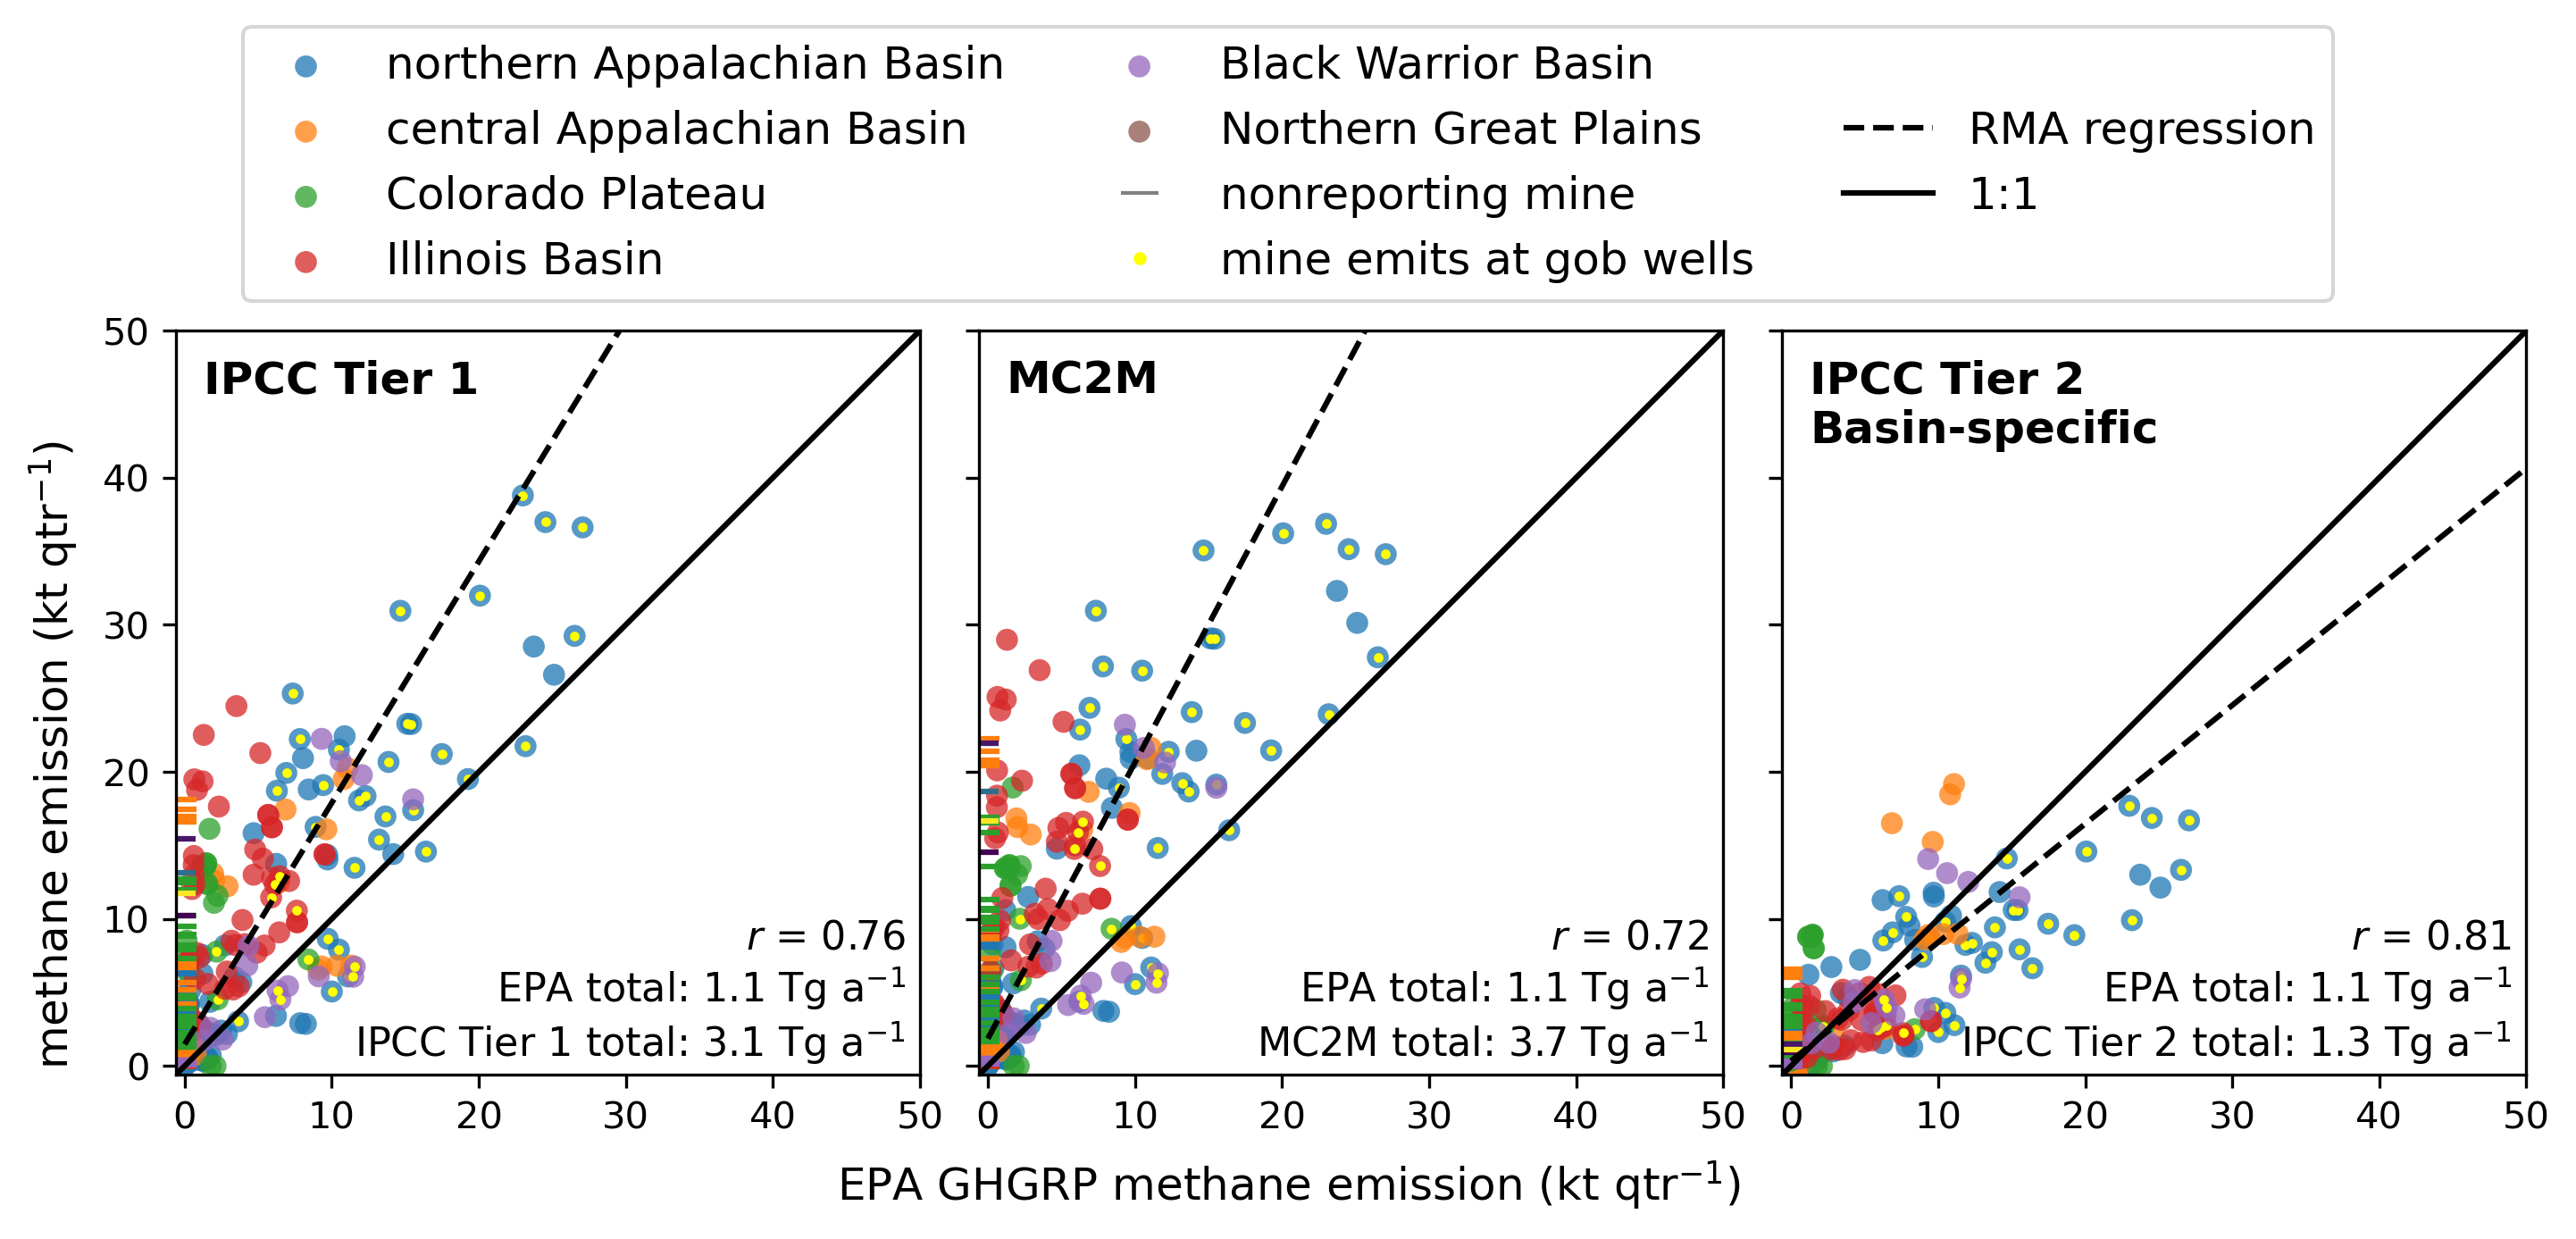

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9.5,3.5), dpi=300, sharey=True, layout='constrained')

order = [2,0,3,1,4,5]
EPA_TOTAL_2022 = 1.124

color_scatter(INVENTORY="IPCC_emis_T" , TITLE="IPCC Tier 1" , COLORS='Basin', figure_letter='a)', ax=ax1, order=order, year=2022, UNIT_CONVERSION=1./1000.)
color_scatter(INVENTORY="Kholod_emis_T" , TITLE="MC2M", COLORS='Basin', figure_letter='b)', ax=ax2, order=order, year=2022, UNIT_CONVERSION=1./1000.)
m = color_scatter(INVENTORY="Basin_emis_T", TITLE="IPCC Tier 2\nBasin-specific", COLORS='Basin', figure_letter='c)', order=order, ax=ax3, year=2022, UNIT_CONVERSION=1./1000.)

# Customize legend
custom_lines = [
    Line2D([0], [0], color='gray', marker='_', linestyle='None', markersize=10, label='nonreporting mine'),
    Line2D([0], [0], color='yellow', marker='.', linestyle='None', markersize=5, label='mine emits at gob wells')
]
spacer = Line2D([0], [0], color='white', marker='_', linestyle='None', markersize=10, label=' ')
handles, labels = ax3.get_legend_handles_labels()
handles = handles[:-2] + custom_lines + [spacer] + handles[-2:]  # move custom lines to the middle of the legend
labels = labels[:-2] + ['nonreporting mine', 'mine emits at gob wells'] + [''] + labels[-2:]  
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.3), ncol=3, fontsize=12)

plt.subplots_adjust(wspace=0)
fig.supylabel(r"methane emission $\mathrm{(kt\ qtr^{-1})}$")
fig.supxlabel(r"EPA GHGRP methane emission $\mathrm{(kt\ qtr^{-1})}$")

plt.savefig('./figures/figure_4.png', bbox_inches='tight')
m

/tmp/ipykernel_12672/1035440407.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/1035440407.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/1035440407.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which s

Basin_emis_T
slope: 0.6992331442706952
1.0
Basin_emis_T
slope: 0.9676090594484764
1.0


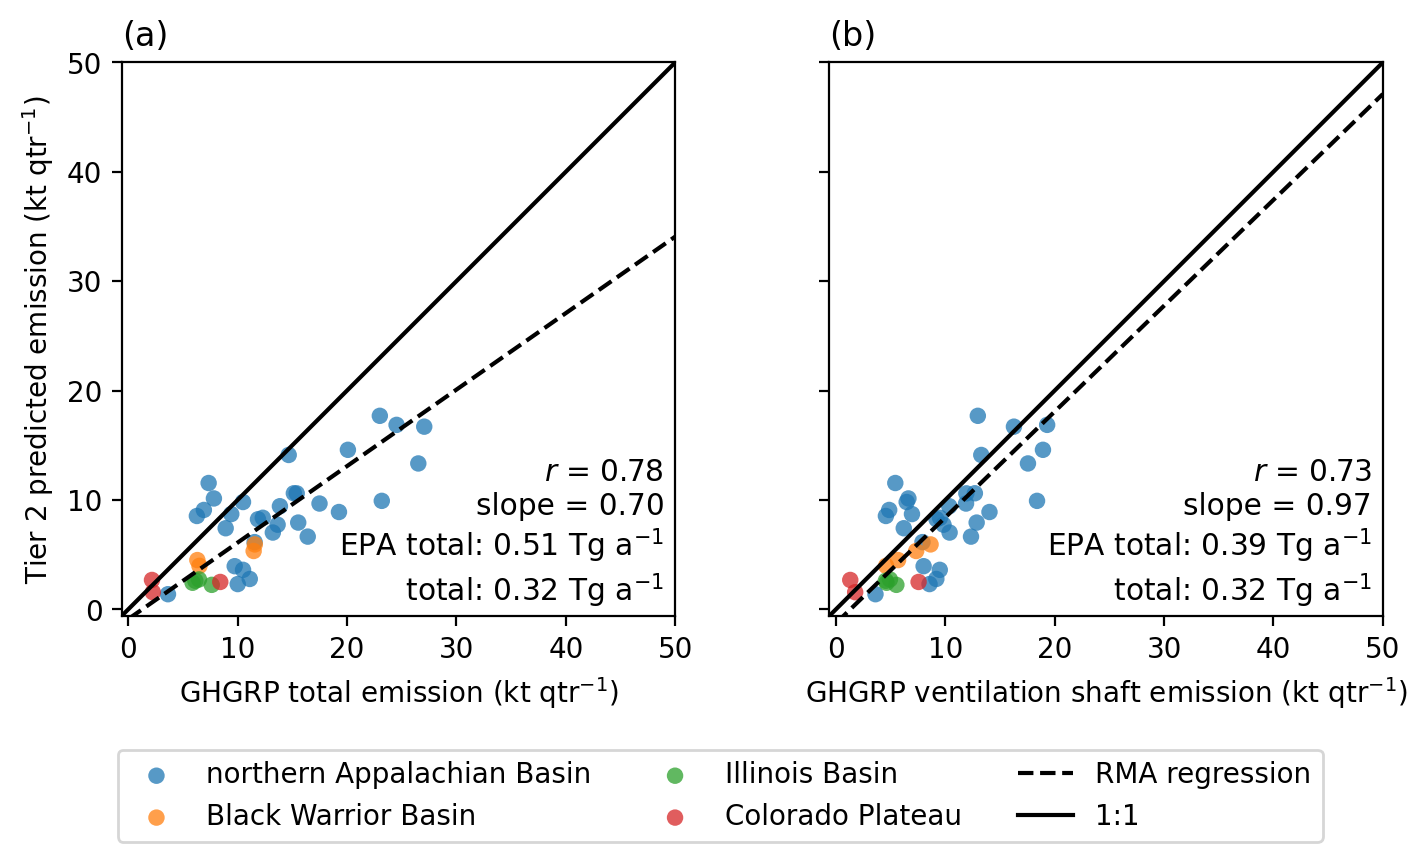

In [64]:
import matplotlib.pyplot as plt

# Filter the data
mines_that_degas = emission_comparison[emission_comparison['epa_degas_true_M_T'] > 0]

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=200, sharey=True)

# First subplot (a)
color_scatter(
    INVENTORY="Basin_emis_T",
    TITLE="",
    COLORS='Basin',
    figure_letter='(a)',
    ax=axs[0],
    year=2022,
    UNIT_CONVERSION=1./1000.,
    df_in=mines_that_degas,
    separate_gob_wells=False,
    plot_slope=True,
)
axs[0].set_title("(a)", loc='left', fontsize=12)
axs[0].set_xlabel("GHGRP total emission (kt qtr$^{-1}$)")
axs[0].set_ylabel("Tier 2 predicted emission (kt qtr$^{-1}$)")

# Second subplot (b)
color_scatter(
    INVENTORY="Basin_emis_T",
    TITLE="",
    COLORS='Basin',
    ycol='epa_vent_true_T',
    figure_letter='(b)',
    ax=axs[1],
    year=2022,
    UNIT_CONVERSION=1./1000.,
    df_in=mines_that_degas,
    separate_gob_wells=False,
    plot_slope=True,
)
axs[1].set_title("(b)", loc='left', fontsize=12)
axs[1].set_xlabel("GHGRP ventilation shaft emission (kt qtr$^{-1}$)")

# Get legend handles and labels from one of the axes
handles, labels = axs[0].get_legend_handles_labels()

# Create a single legend below the plots
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.525, -0.05), fontsize=10)

# Adjust layout to make space
plt.tight_layout()
plt.subplots_adjust(bottom=0.25, left=0.12)  # Adjust left for y-label space

plt.show()


In [65]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11.5,4), dpi=300, sharey=True, layout='constrained')

# color_scatter(INVENTORY="IPCC_emis_T" , TITLE="IPCC Tier 1" , COLORS='Basin', figure_letter='a)', ax=ax1, year=2019, ycol='epa_vent_true_T')
# color_scatter(INVENTORY="Kholod_emis_T" , TITLE="MC2M", COLORS='Basin', figure_letter='b)', ax=ax2, year=2019, ycol='epa_vent_true_T')
# m = color_scatter(INVENTORY="Basin_emis_T", TITLE="IPCC Tier 2", COLORS='Basin', figure_letter='c)', ax=ax3, year=2019, ycol='epa_vent_true_T')
# fig.legend(*ax3.get_legend_handles_labels(), loc = "upper center", bbox_to_anchor=(0.5, 1.22,), ncol=3, fontsize=12)
# plt.subplots_adjust(wspace=0)
# fig.supylabel('predicted methane emission (T)')
# fig.supxlabel('EPA methane emission (T)')

# m

GEM_emis_T
slope: 0.9880482949100539
1.0


/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

,State,Mean Percent Bias,Mean Bias,RMSPE,inventory total (Tg),EPA total (Tg),bias of total (%),emission factor
0,Central Appalachian Basin,2459.7,6894.3,420.4,0.1,0.1,-31.6,NaN
1,Illinois Basin,564.1,8883.5,250.5,0.3,0.2,52.7,NaN
2,Northern Appalachian Basin,514.0,4847.3,236.6,0.8,0.7,24.7,NaN
3,Southwest and Rockies Basin,2974.7,8773.0,527.8,0.6,0.0,1761.9,NaN
4,Warrior Basin,4.6,171.2,73.8,0.1,0.1,2.3,NaN
5,North Great Plains Basin,inf,15117.5,inf,0.1,0.0,inf,NaN


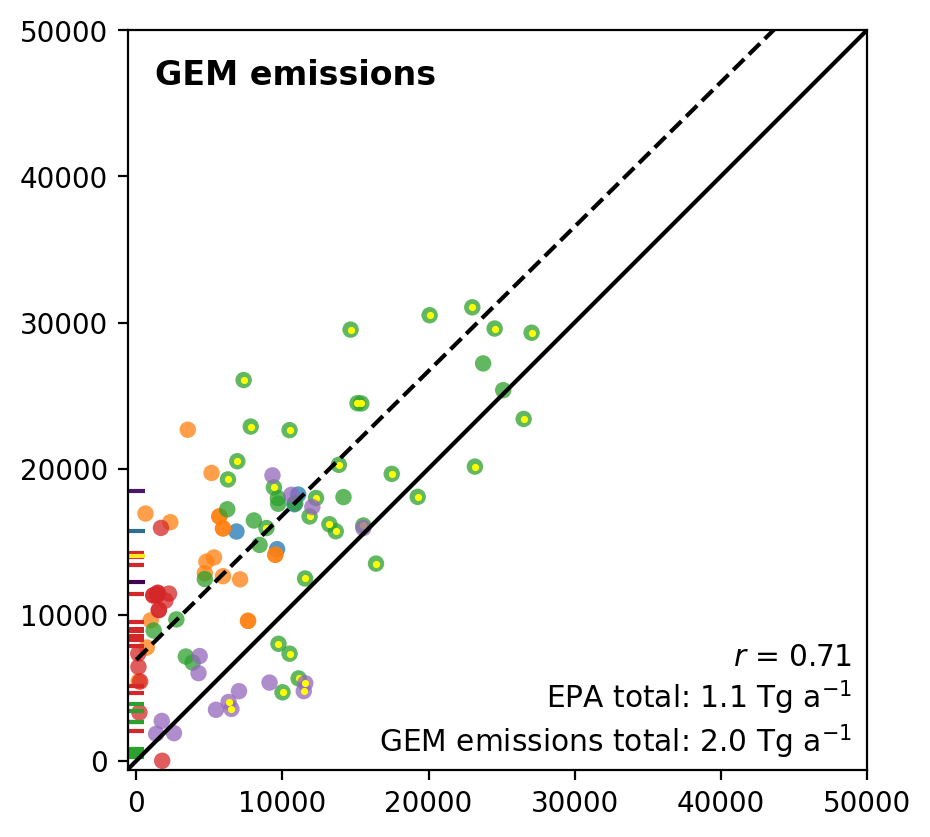

In [18]:
INVENTORY = "GEM_emis_T" # 'GEM_emis_T', 'Kholod_emis_T', 'IPCC_emis_T'
TITLE = "GEM emissions" 
COLORS = 'Basin'
color_scatter(INVENTORY, TITLE, COLORS, figure_letter='')

In [19]:
# emission_comparison[(emission_comparison['CAL_YR']==2021)&
#                     (emission_comparison['Basin']=='Northern Appalachian Basin')&
#                     (emission_comparison['CAL_QTR']==2)]

In [20]:
# 2) assign if a mine was actually observed, calculate the EPA sum and CM raw sum. 
# 3) plot the raw sum 

In [21]:
pd.set_option('display.max_rows', None)
emission_comparison[(emission_comparison['Basin']=='Northern Appalachian Basin')&(~emission_comparison['well_emission_auto'].isnull())][
    ['Mine Name','epa_vent_true_T', 'epa_degas_true_T', 'well_emission_auto','vent_emission_auto','year_quarter',]].sort_values(by='year_quarter').sort_values(by='Mine Name').sum()

Mine Name             Bailey Coal MineCumberland Coal MineEnlow Fork...
epa_vent_true_T                                                74252.17
epa_degas_true_T                                               21449.83
well_emission_auto                                         21657.269367
vent_emission_auto                                         96099.437529
year_quarter                                                   10113.75
dtype: object

In [22]:
emission_comparison.columns[emission_comparison.columns.str.contains('EF')]

Index(['CM_EF', 'CM_min_EF', 'CM_max_EF', 'CM_well_EF', 'CM_well_min_EF',
       'CM_well_max_EF', 'EPA_EF', 'IPCC_EF', 'IPCC_EF_CoalAge', 'Kholod_EF',
       'GEM_EF', 'Kholod_EF_CoalAge', 'GEM_EF_CoalAge', 'Basin_EF'],
      dtype='object')

<Axes: xlabel='Basin'>

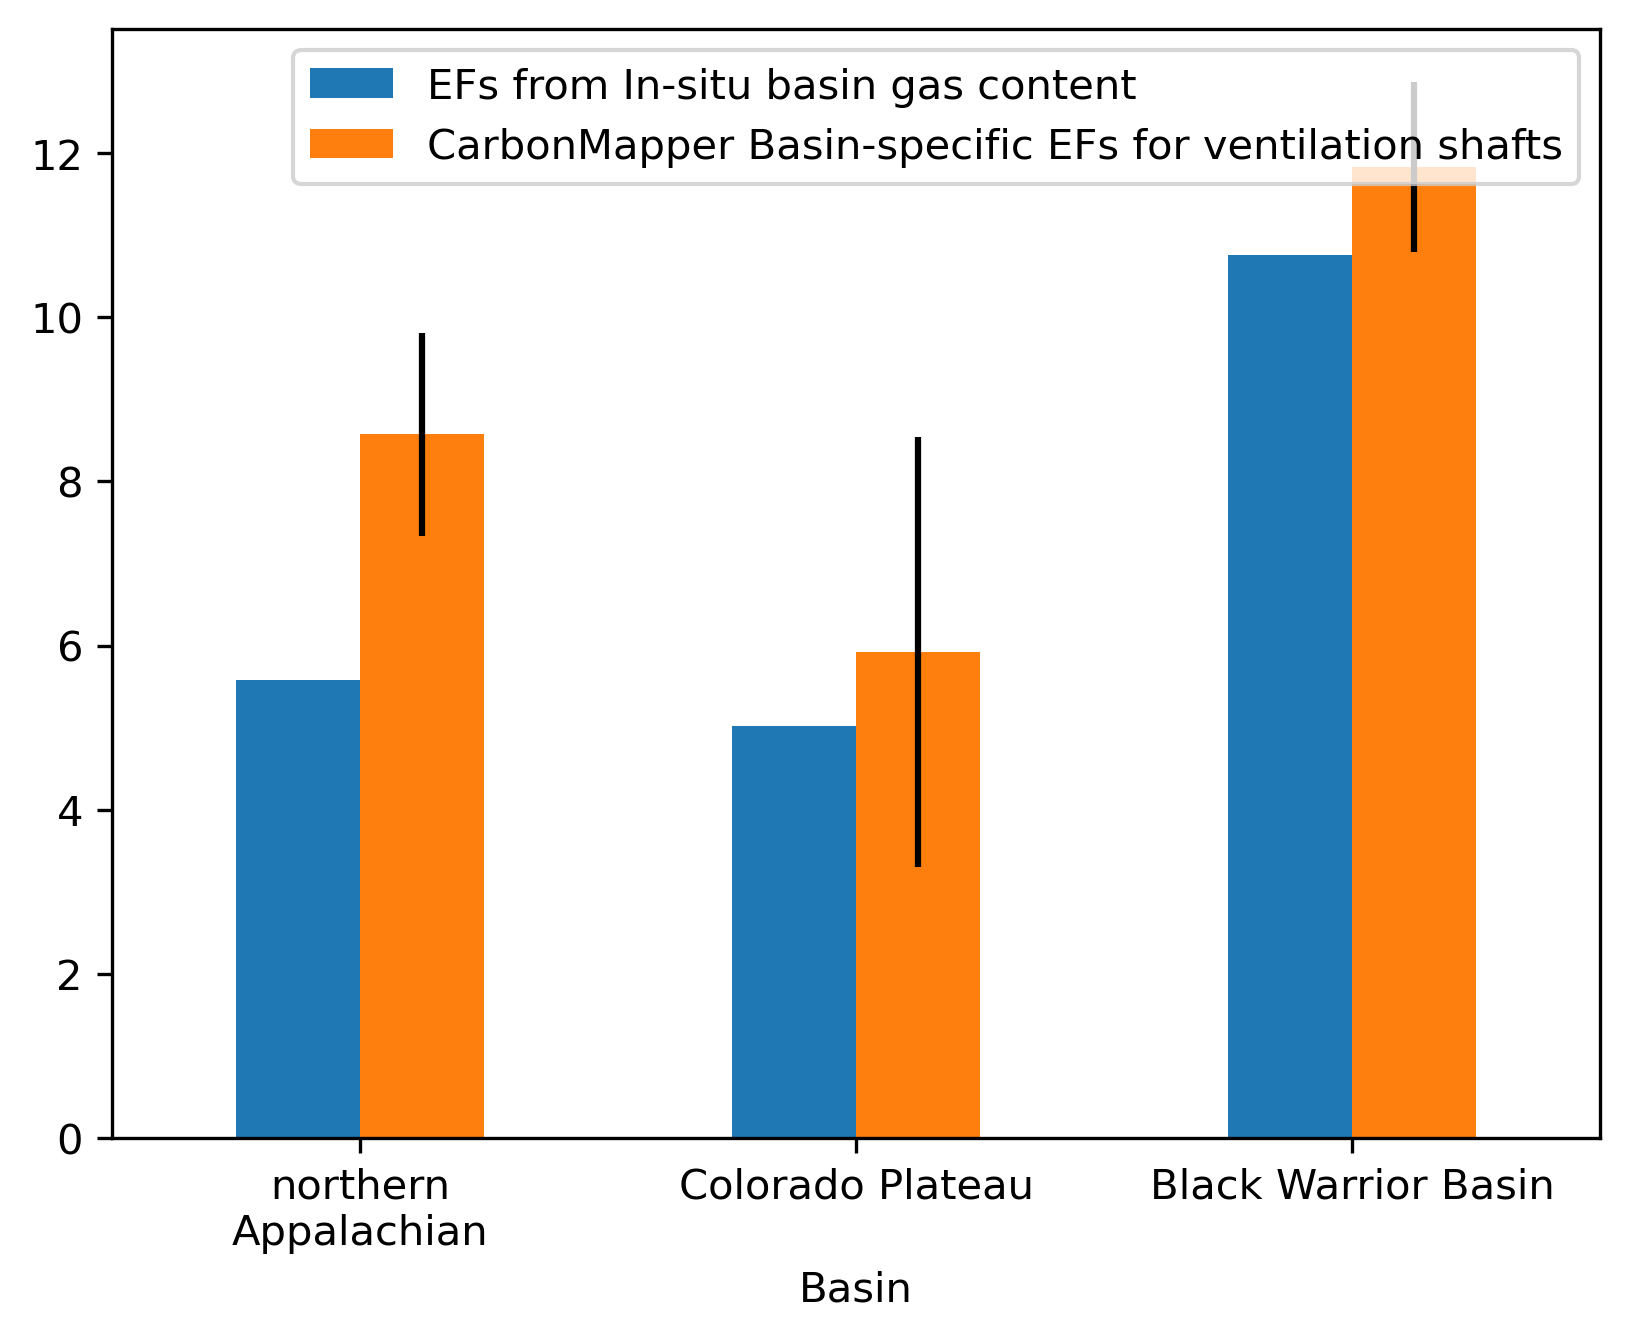

In [23]:
basin_names = {
    'Central Appalachian Basin': 'central\nAppalachian',
    'Illinois Basin': 'Illinois',
    'North Great Plains Basin': 'Northern\nGreat Plains',
    'Northern Appalachian Basin': 'northern\nAppalachian',
    'Southwest and Rockies Basin': 'Colorado Plateau',
    'Warrior Basin': 'Black Warrior Basin',
    'US total': 'US total'}

inventory_names = {
    'Basin_EF': 'EFs from In-situ basin gas content', 
    'CM_EF': 'CarbonMapper Basin-specific EFs for ventilation shafts' }

efs = emission_comparison[['Basin', 'CM_EF', 'CM_min_EF', 'CM_max_EF', 'Basin_EF']].groupby('Basin').mean()
efs['Basin_EF'] = efs['Basin_EF'] * M3_TO_KG # kg / ton
efs[['CM_EF', 'CM_min_EF', 'CM_max_EF']] = efs[['CM_EF', 'CM_min_EF', 'CM_max_EF']] * 1 / utils.MT_QRT_TO_KG_HR / utils.M_T_TO_T / utils.KG_TO_M_T # kg / ton
ef_errs = efs[['Basin_EF', 'CM_EF']].copy()
ef_errs.loc[:,:] = 0.
ef_errs['CM_EF'] = (efs['CM_max_EF'] - efs['CM_min_EF']) / 2. 
fig, ax = plt.subplots(dpi=300)
efs.loc[['Northern Appalachian Basin', 'Southwest and Rockies Basin', 'Warrior Basin'],['Basin_EF', 'CM_EF']
        ].rename(index=basin_names, columns=inventory_names
                 ).plot(kind='bar', yerr=ef_errs.rename(index=basin_names, columns=inventory_names), ax=ax, rot=0)

<Axes: xlabel='CM_well_emis_T', ylabel='epa_degas_true_T'>

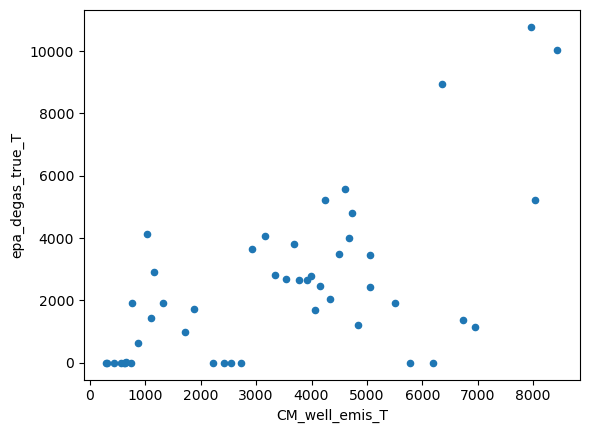

In [24]:
emission_comparison[emission_comparison['CM_well_emis_T']>0][['Mine Name','CAL_YR','CAL_QTR','CM_well_emis_T','epa_degas_true_T']].plot(
    x='CM_well_emis_T',
    y='epa_degas_true_T',
    kind='scatter'
)

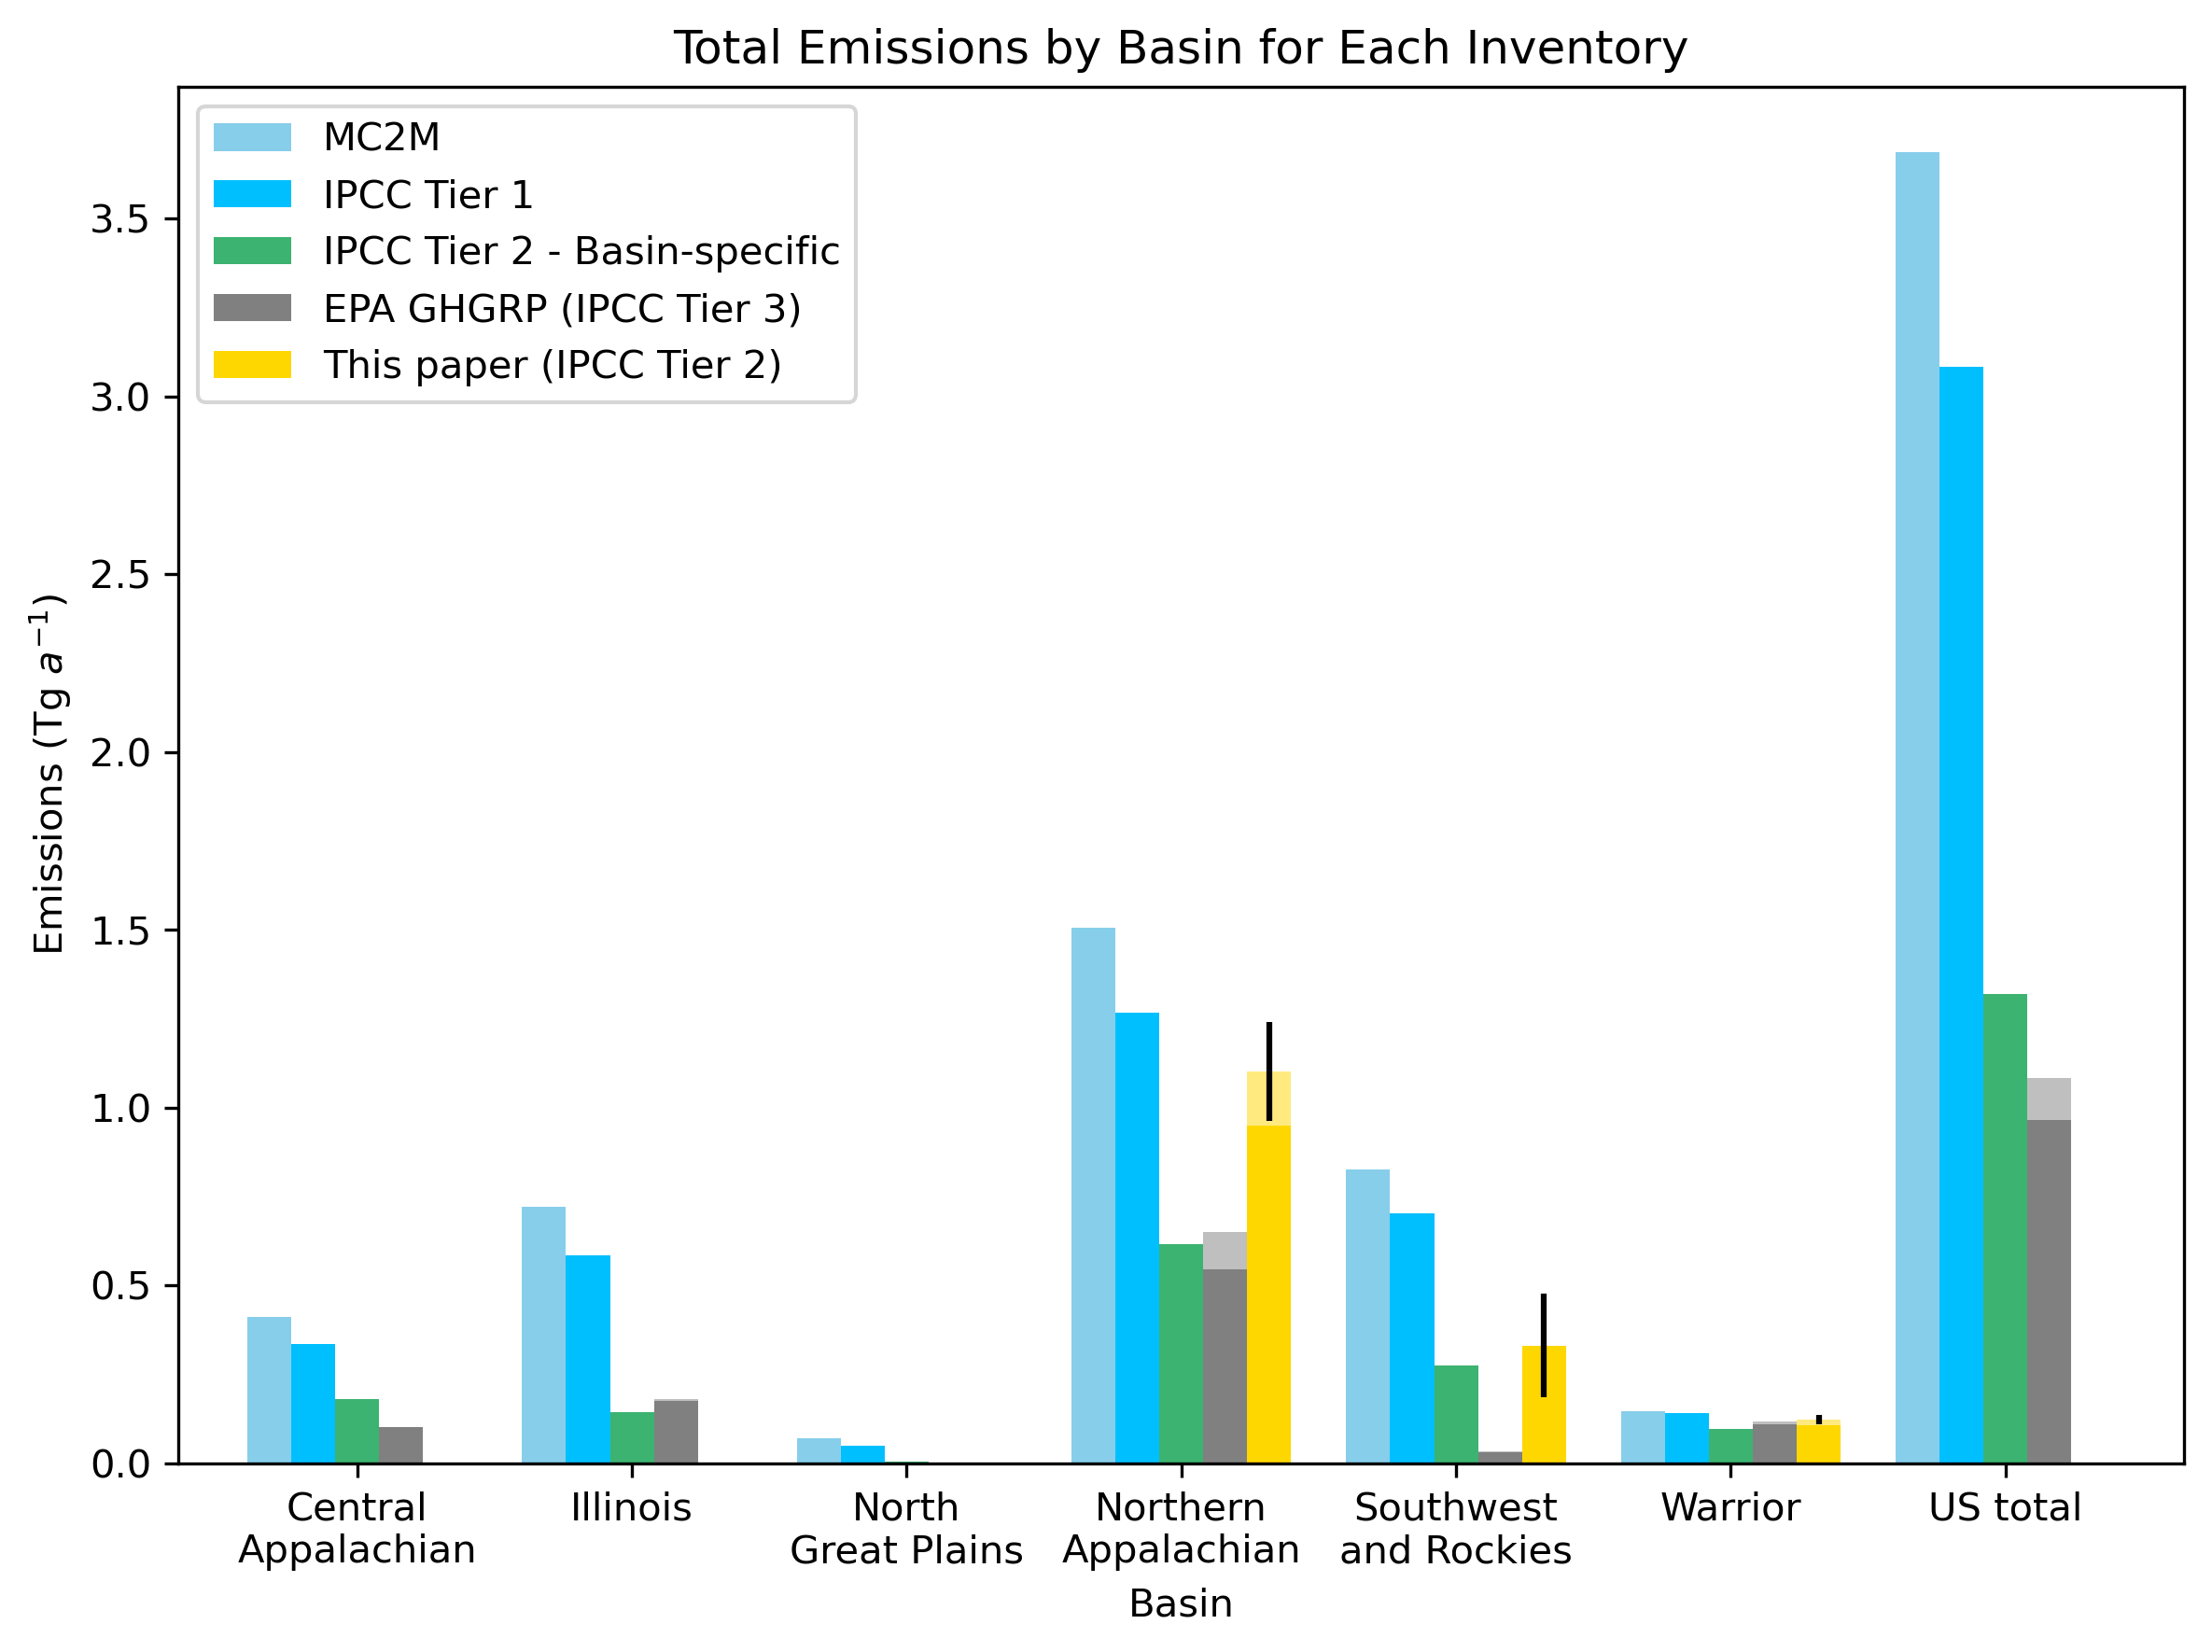

In [25]:
N_YEARS = (END_YEAR-START_YEAR+1)

# make a table with total emissions by basin for each inventory
vent_comparison = (emission_comparison.groupby(['Basin'])[[ 
                                    'Kholod_emis_T', 
                                    'IPCC_emis_T', 
                                    'Basin_emis_T', 
                                    'epa_vent_true_T',
                                    'CM_vent_emis_T',
                                    ]].sum()/N_YEARS/1e6
                                    ).reset_index().groupby('Basin').mean()
vent_comparison.loc['US total',:] = vent_comparison.sum(axis=0)
vent_comparison = vent_comparison.reset_index()
vent_comparison.loc[~vent_comparison['Basin'].isin(['Warrior Basin', 
                                                    'Southwest and Rockies Basin', 
                                                    'Northern Appalachian Basin']), 'CM_vent_emis_T'] = np.nan

total_comparison = (emission_comparison.groupby(['Basin'])[[ 
                                    'Kholod_emis_T', 
                                    'IPCC_emis_T', 
                                    'Basin_emis_T', 
                                    'epa_true_T',
                                    'CM_vent_plus_well_emis_T',
                                    ]].sum()/N_YEARS/1e6
                                    ).reset_index().groupby('Basin').mean()
total_comparison.loc['US total',:] = total_comparison.sum(axis=0)
total_comparison = total_comparison.reset_index()
total_comparison.loc[~total_comparison['Basin'].isin([ 
                                                    'Northern Appalachian Basin', 'Warrior Basin', 'Southwest and Rockies Basin']), 
                                                    'CM_vent_plus_well_emis_T'] = np.nan
total_comparison = total_comparison.rename({
                                        'Kholod_emis_T':'MC2M', 
                                        'IPCC_emis_T': 'IPCC Tier 1', 
                                        'Basin_emis_T': 'IPCC Tier 2', 
                                        'CM_vent_plus_well_emis_T': 'CarbonMapper EFs',
                                        'epa_true_T': 'EPA GHGRP' },axis=1)

# get errors
minmax_vent = (emission_comparison.groupby(['Basin'])[['CM_min_emis_T', 'CM_max_emis_T']].sum()/N_YEARS/1e6
                                    ).reset_index().groupby('Basin').mean()
minmax_well = (emission_comparison.groupby(['Basin'])[['CM_well_min_emis_T', 'CM_well_max_emis_T']].sum()/N_YEARS/1e6
                                    ).reset_index().groupby('Basin').mean()
vent_err = (minmax_vent['CM_max_emis_T'] - minmax_vent['CM_min_emis_T']) / 2
well_err = (minmax_well['CM_well_max_emis_T'] - minmax_well['CM_well_min_emis_T']) / 2
total_err = np.sqrt(vent_err**2 + well_err**2).groupby('Basin').mean()
err_df = total_comparison.copy().set_index('Basin')
err_df.loc[:,:] = 0.
err_df.loc[:,'CarbonMapper EFs'] = total_err
err_df = err_df.reset_index().fillna(0.)

# clean up names
inventory_names = {
    'Kholod_emis_T':'MC2M', 
    'IPCC_emis_T': 'IPCC Tier 1', 
    'Basin_emis_T': 'IPCC Tier 2 - Basin-specific', 
    'CM_vent_emis_T': 'This paper (IPCC Tier 2)',
    'epa_vent_true_T': 'EPA GHGRP (IPCC Tier 3)' }

basin_names = {
    'Central Appalachian Basin': 'Central\nAppalachian',
    'Illinois Basin': 'Illinois',
    'North Great Plains Basin': 'North\nGreat Plains',
    'Northern Appalachian Basin': 'Northern\nAppalachian',
    'Southwest and Rockies Basin': 'Southwest\nand Rockies',
    'Warrior Basin': 'Warrior',
    'US total': 'US total'}
vent_comparison = vent_comparison.rename(columns=inventory_names)
vent_comparison.Basin = vent_comparison.Basin.replace(basin_names)

# Plotting the grouped bar chart\
fig, ax = plt.subplots(dpi=300)
tot_bars = total_comparison.set_index('Basin').plot(kind='bar', yerr=err_df.set_index('Basin'), figsize=(8, 6),
                color=[ 'skyblue', 'deepskyblue' ,'mediumseagreen', 'gray', 'gold'],
                width=0.8, ax=ax, zorder=2,alpha=0.5, legend=False)  
bars = vent_comparison.set_index('Basin').plot(kind='bar', figsize=(8, 6),
                color=[ 'skyblue', 'deepskyblue' ,'mediumseagreen', 'gray', 'gold'], 
                width=0.8, ax=ax, zorder=1, )                     
plt.title(f'Total Emissions by Basin for Each Inventory')
plt.xlabel('Basin')
plt.ylabel('Emissions (Tg $a^{-1})$')
# plt.legend(title='Inventory')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

In [26]:
vent_comparison

,Basin,MC2M,IPCC Tier 1,IPCC Tier 2 - Basin-specific,EPA GHGRP (IPCC Tier 3),This paper (IPCC Tier 2)
0,Central\nAppalachian,0.412175,0.335770,0.181487,0.102147,NaN
1,Illinois,0.722731,0.584249,0.143883,0.175102,NaN
2,North\nGreat Plains,0.071808,0.050548,0.004737,0.000000,NaN
3,Northern\nAppalachian,1.505575,1.267342,0.617593,0.546005,0.948519
4,Southwest\nand Rockies,0.825309,0.703403,0.274590,0.032312,0.331387
5,Warrior,0.147953,0.141741,0.098131,0.109634,0.107899
6,US total,3.685551,3.083052,1.320419,0.965200,NaN


In [27]:
vent_comparison[vent_comparison['Basin'].isin(['Northern Appalachian Basin', 
                                               'Southwest and Rockies Basin', 
                                               'Warrior Basin'])].sum(axis=0)

Basin                           0.0
MC2M                            0.0
IPCC Tier 1                     0.0
IPCC Tier 2 - Basin-specific    0.0
EPA GHGRP (IPCC Tier 3)         0.0
This paper (IPCC Tier 2)        0.0
dtype: float64

In [28]:
pd.DataFrame((vent_comparison['This paper (IPCC Tier 2)'] - vent_comparison['EPA GHGRP (IPCC Tier 3)']) / vent_comparison['EPA GHGRP (IPCC Tier 3)']).set_index(vent_comparison['Basin'])

,0
Basin,
Central\nAppalachian,NaN
Illinois,NaN
North\nGreat Plains,NaN
Northern\nAppalachian,0.737199
Southwest\nand Rockies,9.256002
Warrior,-0.015821
US total,NaN


In [29]:
pd.DataFrame((vent_comparison['This paper (IPCC Tier 2)'] - vent_comparison['IPCC Tier 1']) / vent_comparison['IPCC Tier 1']).set_index(vent_comparison['Basin'])

,0
Basin,
Central\nAppalachian,NaN
Illinois,NaN
North\nGreat Plains,NaN
Northern\nAppalachian,-0.251568
Southwest\nand Rockies,-0.528880
Warrior,-0.238754
US total,NaN


In [30]:
pd.DataFrame((vent_comparison['This paper (IPCC Tier 2)'] - vent_comparison['IPCC Tier 2 - Basin-specific']) / vent_comparison['IPCC Tier 2 - Basin-specific']).set_index(vent_comparison['Basin'])

,0
Basin,
Central\nAppalachian,NaN
Illinois,NaN
North\nGreat Plains,NaN
Northern\nAppalachian,0.535833
Southwest\nand Rockies,0.206845
Warrior,0.099550
US total,NaN


In [31]:
pd.DataFrame((vent_comparison['This paper (IPCC Tier 2)'] - vent_comparison['MC2M']) / vent_comparison['MC2M']).set_index(vent_comparison['Basin'])

,0
Basin,
Central\nAppalachian,NaN
Illinois,NaN
North\nGreat Plains,NaN
Northern\nAppalachian,-0.369995
Southwest\nand Rockies,-0.598469
Warrior,-0.270716
US total,NaN


I think I'd do a comparison of the dark yellow to the dark green and show the range of agreement for the three basins. Then do the same with the dark yellow to dark blue as well. Then simplify the language to basically state that it's a comparison of the two IPCC methods with your result

In [32]:
well_comparison = emission_comparison.groupby(['Basin'])[[ 
                                    'epa_degas_true_T',
                                    'CM_well_emis_T',
                                    ]].sum()/N_YEARS
well_comparison

,epa_degas_true_T,CM_well_emis_T
Basin,,
Central Appalachian Basin,0.00,0.000000
Illinois Basin,6448.58,0.000000
North Great Plains Basin,0.00,0.000000
Northern Appalachian Basin,107113.16,153404.419886
Southwest and Rockies Basin,2193.83,0.000000
Warrior Basin,9588.89,15346.900711


In [33]:
emission_comparison[emission_comparison["COAL_PRODUCTION"]>0].groupby('Basin').nunique()['MINE_ID']

Basin
Central Appalachian Basin       55
Illinois Basin                  12
North Great Plains Basin         1
Northern Appalachian Basin     102
Southwest and Rockies Basin     11
Warrior Basin                    6
Name: MINE_ID, dtype: int64

In [34]:
emission_comparison[emission_comparison["COAL_PRODUCTION"]>0].nunique()['MINE_ID']

187

In [35]:
emission_comparison[emission_comparison["COAL_PRODUCTION"]>0].groupby('Basin').sum()['epa_true_T']

/tmp/ipykernel_12672/1722364570.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  emission_comparison[emission_comparison["COAL_PRODUCTION"]>0].groupby('Basin').sum()['epa_true_T']


Basin
Central Appalachian Basin       95348.41
Illinois Basin                 181106.16
North Great Plains Basin            0.00
Northern Appalachian Basin     651625.74
Southwest and Rockies Basin     30637.55
Warrior Basin                  119222.95
Name: epa_true_T, dtype: float64

In [36]:
emission_comparison.groupby('Basin').nunique()['MINE_ID']

Basin
Central Appalachian Basin       96
Illinois Basin                  19
North Great Plains Basin         1
Northern Appalachian Basin     169
Southwest and Rockies Basin     17
Warrior Basin                    8
Name: MINE_ID, dtype: int64

In [37]:
emission_comparison[emission_comparison['epa_degas_true_T']>0].groupby('Basin').nunique()['MINE_ID']

Basin
Illinois Basin                 1
Northern Appalachian Basin     9
Southwest and Rockies Basin    1
Warrior Basin                  1
Name: MINE_ID, dtype: int64

In [38]:
-0.107354, -0.106101

(-0.107354, -0.106101)

In [39]:
total_comparison

,Basin,MC2M,IPCC Tier 1,IPCC Tier 2,EPA GHGRP,CarbonMapper EFs
0,Central Appalachian Basin,0.412175,0.335770,0.181487,0.096418,NaN
1,Illinois Basin,0.722731,0.584249,0.143883,0.181106,NaN
2,North Great Plains Basin,0.071808,0.050548,0.004737,0.000000,NaN
3,Northern Appalachian Basin,1.505575,1.267342,0.617593,0.651626,1.101924
4,Southwest and Rockies Basin,0.825309,0.703403,0.274590,0.034505,0.331387
5,Warrior Basin,0.147953,0.141741,0.098131,0.119223,0.123246
6,US total,3.685551,3.083052,1.320419,1.082879,NaN


In [40]:
vent_comparison

,Basin,MC2M,IPCC Tier 1,IPCC Tier 2 - Basin-specific,EPA GHGRP (IPCC Tier 3),This paper (IPCC Tier 2)
0,Central\nAppalachian,0.412175,0.335770,0.181487,0.102147,NaN
1,Illinois,0.722731,0.584249,0.143883,0.175102,NaN
2,North\nGreat Plains,0.071808,0.050548,0.004737,0.000000,NaN
3,Northern\nAppalachian,1.505575,1.267342,0.617593,0.546005,0.948519
4,Southwest\nand Rockies,0.825309,0.703403,0.274590,0.032312,0.331387
5,Warrior,0.147953,0.141741,0.098131,0.109634,0.107899
6,US total,3.685551,3.083052,1.320419,0.965200,NaN


EPA_emis_T
slope: 0.9306707352889392
1.0


/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

,State,Mean Percent Bias,Mean Bias,RMSPE,inventory total (Tg),EPA total (Tg),bias of total (%),emission factor
0,Central Appalachian Basin,194.8,545.9,167.3,0.3,0.1,194.8,NaN
1,Illinois Basin,-12.0,-189.7,46.3,0.2,0.2,-12.0,NaN
2,Northern Appalachian Basin,10.7,100.7,50.5,0.7,0.7,10.7,NaN
3,Southwest and Rockies Basin,345.8,1019.9,93.9,0.2,0.0,345.8,NaN
4,Warrior Basin,-3.8,-139.8,38.7,0.1,0.1,-3.8,NaN
5,North Great Plains Basin,NaN,NaN,NaN,0.0,0.0,NaN,NaN


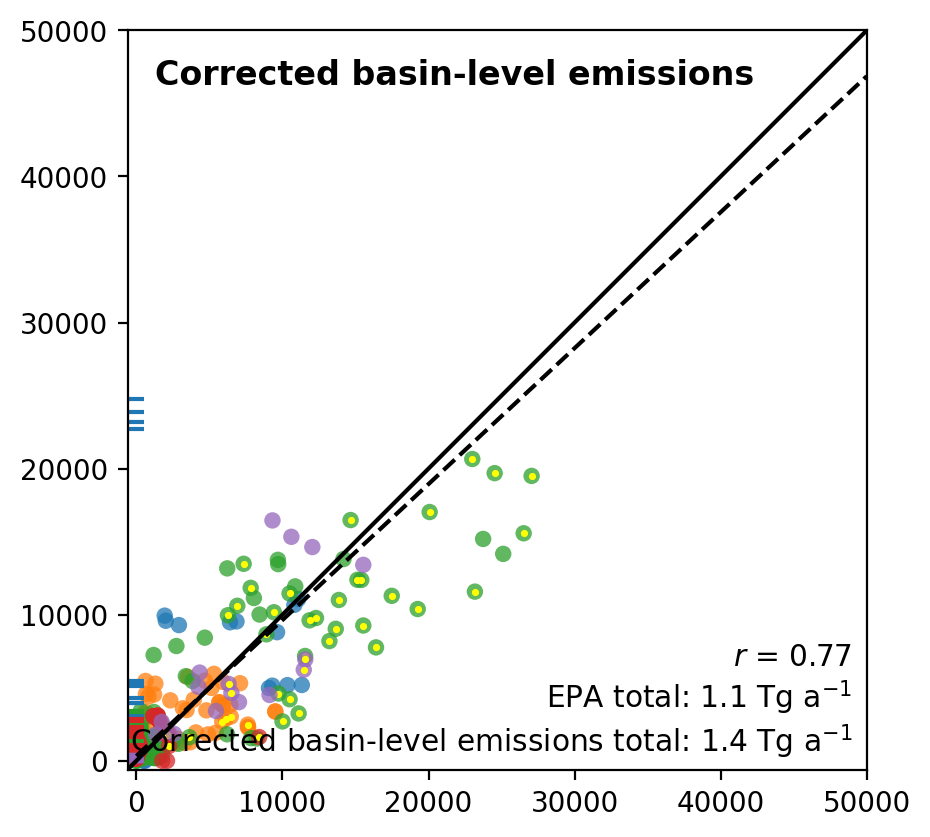

In [41]:
INVENTORY = "EPA_emis_T" # 'GEM_emis_T', 'Kholod_emis_T', 'IPCC_emis_T' 
TITLE = "Corrected basin-level emissions" 
COLORS = 'Basin'

color_scatter(INVENTORY, TITLE, COLORS, figure_letter='c)')

/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,


CM_vent_emis_T
slope: 1.057732384619755
1.0


/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

,State,Mean Percent Bias,Mean Bias,RMSPE,inventory total (Tg),EPA total (Tg),bias of total (%),emission factor
0,Central Appalachian Basin,NaN,NaN,NaN,0.0,0.1,-100.0,NaN
1,Illinois Basin,NaN,NaN,NaN,0.0,0.2,-100.0,NaN
2,Northern Appalachian Basin,45.6,429.7,52.8,0.9,0.7,45.6,NaN
3,Southwest and Rockies Basin,860.4,2537.5,195.6,0.3,0.0,860.4,NaN
4,Warrior Basin,-9.5,-353.9,37.8,0.1,0.1,-9.5,NaN
5,North Great Plains Basin,NaN,NaN,NaN,0.0,0.0,NaN,NaN


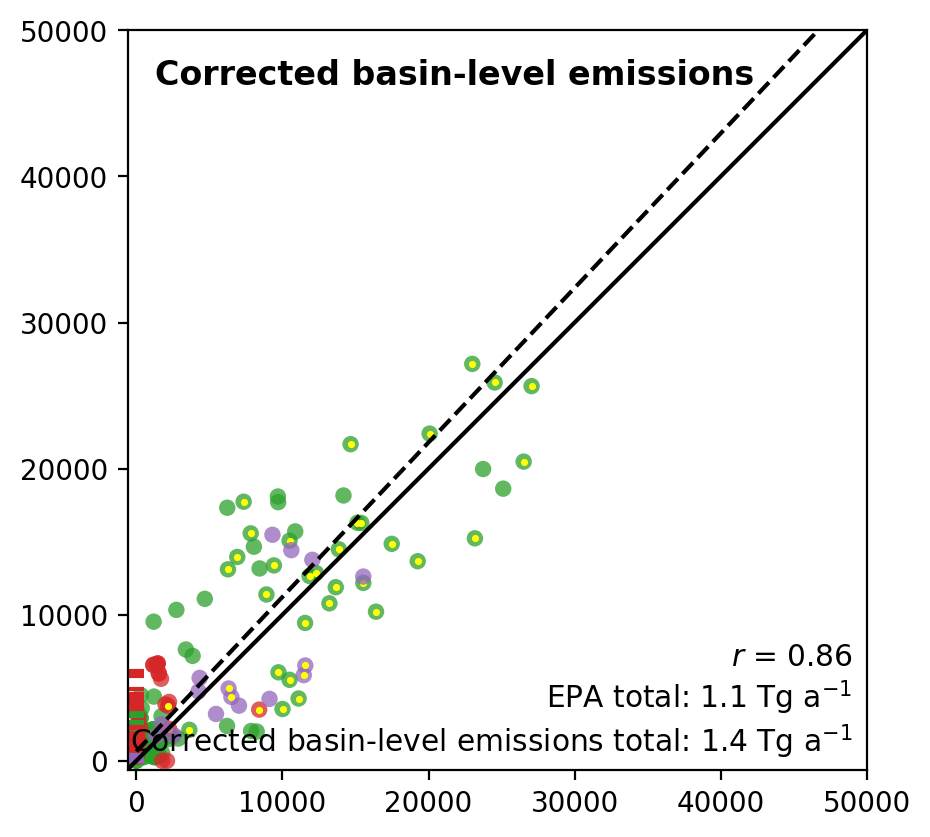

In [42]:
INVENTORY = "CM_vent_emis_T" # 'GEM_emis_T', 'Kholod_emis_T', 'IPCC_emis_T' 
TITLE = "Corrected basin-level emissions" 
COLORS = 'Basin'

color_scatter(INVENTORY, TITLE, COLORS, figure_letter='c)')

Basin_emis_T
slope: 0.8060963548906326
1.0


/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

,State,Mean Percent Bias,Mean Bias,RMSPE,inventory total (Tg),EPA total (Tg),bias of total (%),emission factor
0,Central Appalachian Basin,88.2,247.3,69.7,0.2,0.1,88.2,NaN
1,Illinois Basin,-20.6,-323.7,46.8,0.1,0.2,-20.6,NaN
2,Northern Appalachian Basin,-5.2,-49.3,55.5,0.6,0.7,-5.2,NaN
3,Southwest and Rockies Basin,695.8,2052.0,172.6,0.3,0.0,695.8,NaN
4,Warrior Basin,-17.7,-659.1,38.2,0.1,0.1,-17.7,NaN
5,North Great Plains Basin,inf,1184.1,inf,0.0,0.0,inf,NaN


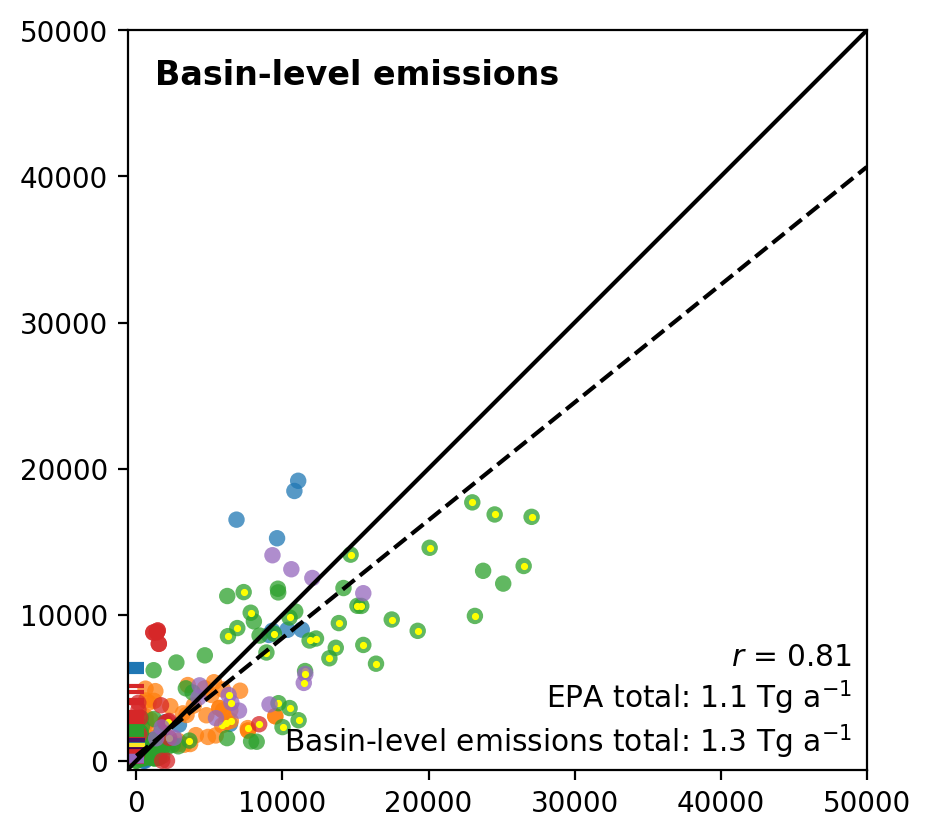

In [43]:
INVENTORY = "Basin_emis_T" # 'GEM_emis_T', 'Kholod_emis_T', 'IPCC_emis_T' 
TITLE = "Basin-level emissions" 
COLORS = 'Basin'

color_scatter(INVENTORY, TITLE, COLORS, figure_letter='c)')

/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,


GEM_emis_T
slope: 0.9880482949100539
1.0


/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

,State,Mean Percent Bias,Mean Bias,RMSPE,inventory total (Tg),EPA total (Tg),bias of total (%),emission factor
0,VA,755.8,6894.3,233.0,0.1,0.1,-15.9,NaN
1,IL,787.4,8883.5,296.0,0.3,0.1,152.7,NaN
2,WV,744.3,5803.2,291.8,0.5,0.4,39.5,NaN
3,UT,9812.0,9087.1,968.9,0.5,0.0,6501.9,NaN
4,PA,139.4,2756.3,107.7,0.3,0.3,8.9,NaN
5,KY,NaN,NaN,NaN,0.0,0.0,-100.0,NaN
6,OH,NaN,NaN,NaN,0.0,0.0,-100.0,NaN
7,CO,1939.7,7693.3,407.1,0.1,0.0,1034.5,NaN
8,AL,4.6,171.2,73.8,0.1,0.1,2.3,NaN
9,IN,NaN,NaN,NaN,0.0,0.1,-100.0,NaN


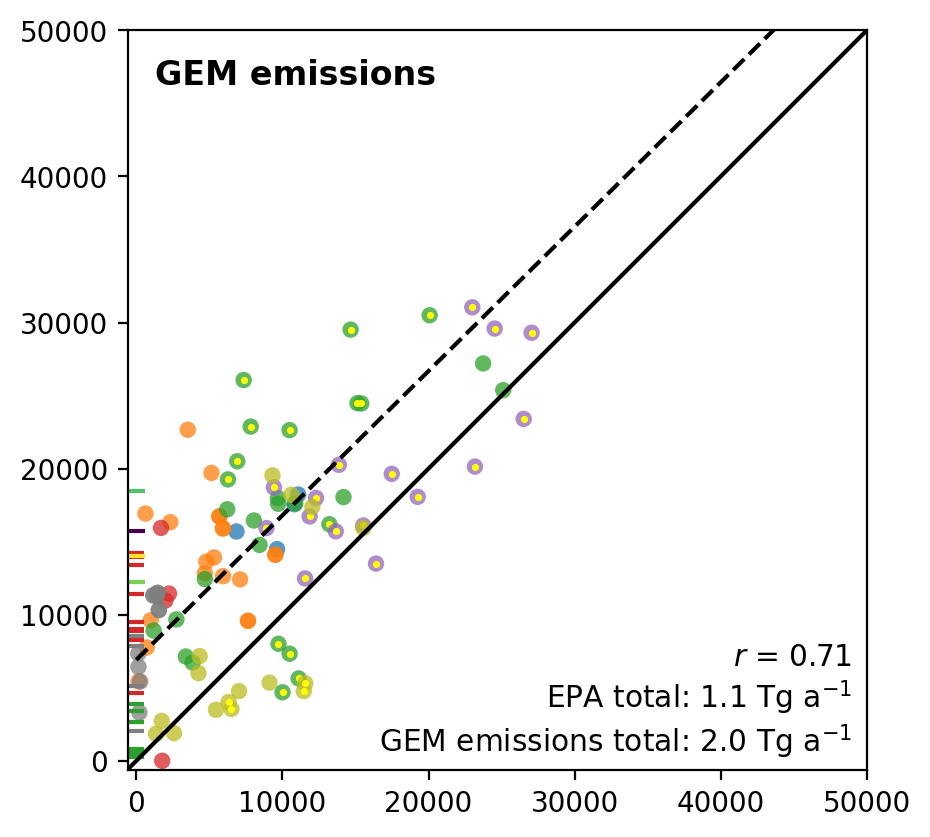

In [44]:
INVENTORY = "GEM_emis_T" # 'GEM_emis_T', 'Kholod_emis_T', 'IPCC_emis_T'
TITLE = "GEM emissions" 
COLORS = 'STATE'

color_scatter(INVENTORY, TITLE, COLORS)

In [45]:
emission_comparison.columns

Index(['MINE_ID', 'CURR_MINE_NM', 'STATE', 'SUBUNIT_CD', 'SUBUNIT', 'CAL_YR',
       'CAL_QTR', 'FISCAL_YR', 'FISCAL_QTR', 'AVG_EMPLOYEE_CNT',
       ...
       'well_emission_uncertainty_auto', 'vent_observed', 'well_observed',
       'vent_vent_id', 'well_vent_id', 'total_emission_auto', 'total_vent_id',
       'total_observed', 'total_emission_uncertainty_auto',
       'CM_vent_plus_well_emis_T'],
      dtype='object', length=135)

In [46]:
plt.get_cmap('tab10')([0,2,4])

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ]])

CM_vent_emis_T
slope: 1.057732384619755
1.3445993473305313


/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[ycol][(mask)&(~df.reports_to_epa)] * UNIT_CONVERSION,
/tmp/ipykernel_12672/240724657.py:48: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which shou

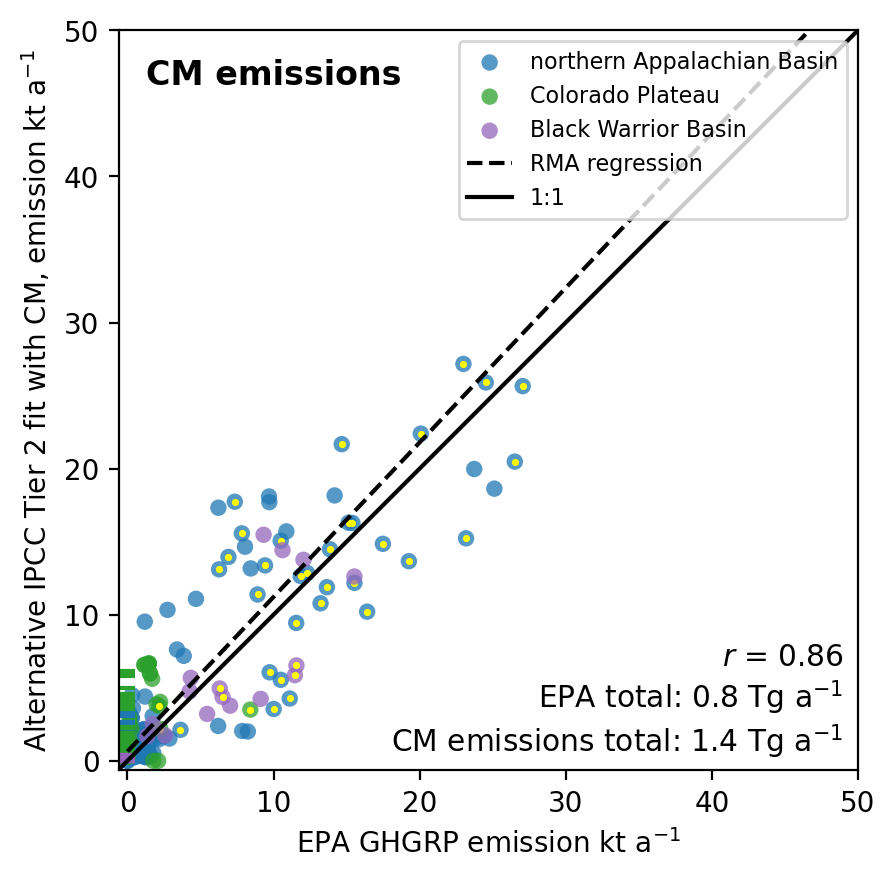

In [47]:
INVENTORY = "CM_vent_emis_T" # 'GEM_emis_T', 'Kholod_emis_T', 'IPCC_emis_T'
TITLE = "CM emissions" 
COLORS = 'Basin'


color_scatter(INVENTORY, TITLE, COLORS, 
              order=[2,3,4], EPA_TOTAL = emission_comparison[emission_comparison.Basin.isin(
                  ['Northern Appalachian Basin', 
                  'Southwest and Rockies Basin', 
                  'Warrior Basin']
                  )]['epa_true_T'].sum()/1e6,
                  cmap= ListedColormap(plt.get_cmap('tab10')([0,2,4])),
                  UNIT_CONVERSION=1./1000.
                  )
plt.ylabel("Alternative IPCC Tier 2 fit with CM, emission kt a$^{-1}$")
plt.xlabel("EPA GHGRP emission kt a$^{-1}$")
plt.legend(fontsize=8, loc=1)

In [48]:
def compare_hist(df_in, epa_col, inventory_col, title, bins=50):
    plt.figure(figsize=(10, 5))
    df = df_in.copy().dropna(subset=[epa_col, inventory_col])
    plt.hist(df[epa_col], bins=bins, alpha=0.5, label='EPA GHGRP')
    plt.hist(df[inventory_col], bins=bins, alpha=0.5, label=inventory_col)
    plt.text(0.75, 0.5, 
             f'EPA GHGRP total: {df[epa_col].sum()/1e6:0.1f} Million Tons\n Inventory total: {df[inventory_col].sum()/1e6:0.1f} Million Tons', 
             transform=plt.gca().transAxes, horizontalalignment='right'),
    plt.title(title)
    plt.xlabel('emissions (metric tons/quarter)')
    plt.ylabel('# of facilities')
    plt.legend()
    plt.show()

In [49]:
def plot_hist_nonreporting_coal_mines(df, inventory_col, title='', bins=50):
    nonreported_coal = df[inventory_col][df['epa_true_T'].isnull()]
    plt.hist(nonreported_coal, bins=bins)
    plt.title('GEM emissions (non-reporting coal mines)')
    plt.xlabel('emissions (metric tons/quarter)')
    plt.ylabel('# of facilities')
    plt.text(0.75, 0.5, 
            f'Maximum EPA total: {704.45*len(nonreported_coal)/1e6:0.1f} Million Tons\n Inventory total: {nonreported_coal.sum()/1e6:0.1f} Million Tons', 
            transform=plt.gca().transAxes, horizontalalignment='right'),
    plt.title(title)
    plt.axvline(704.45, color='r', linestyle='dashed', linewidth=2, label='approximate EPA cutoff for reporting')
    plt.legend()

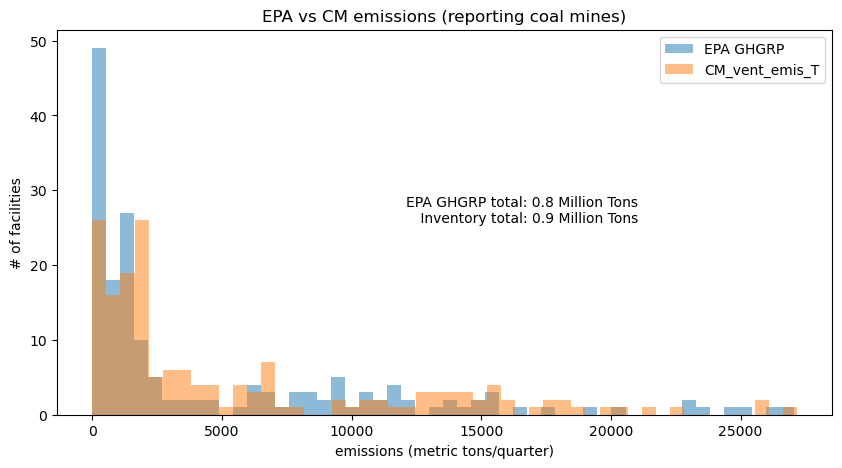

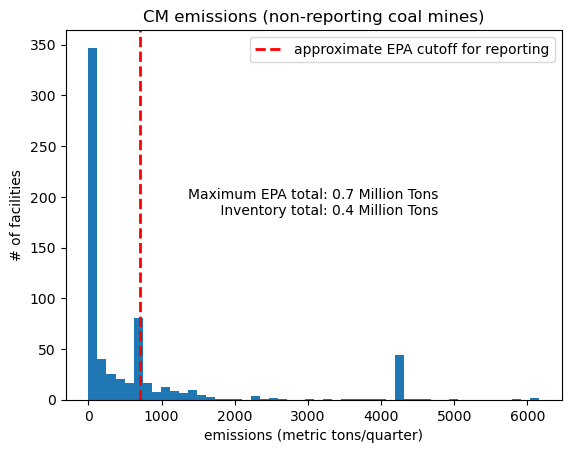

In [50]:
compare_hist(emission_comparison, 'epa_true_T', 'CM_vent_emis_T', 'EPA vs CM emissions (reporting coal mines)')
plot_hist_nonreporting_coal_mines(emission_comparison, 'CM_vent_emis_T', title='CM emissions (non-reporting coal mines)')
# error_metrics(x, y)

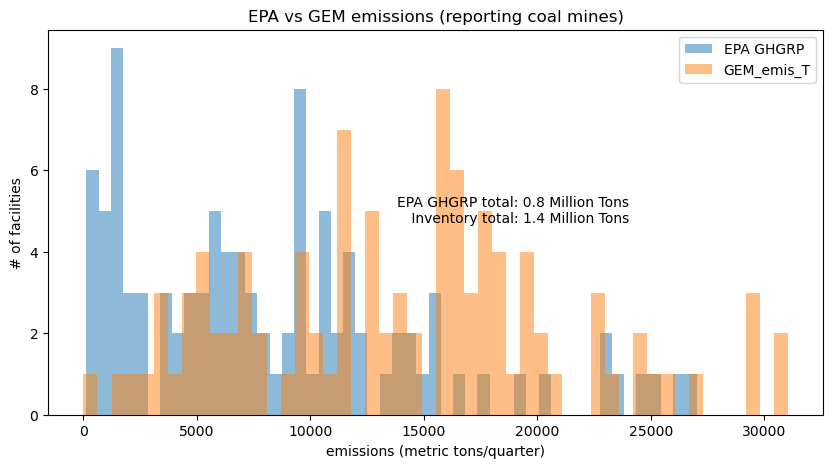

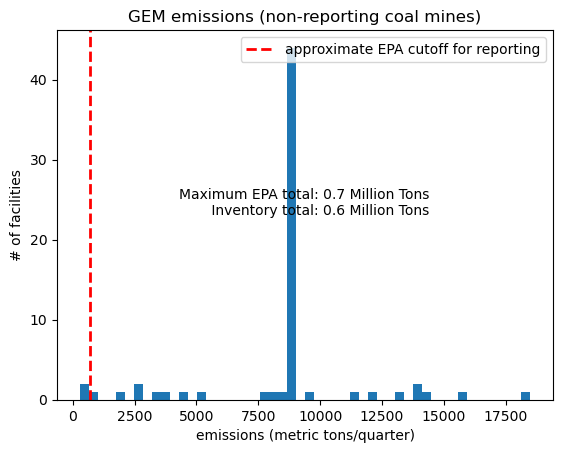

In [51]:
compare_hist(emission_comparison, 'epa_true_T', 'GEM_emis_T', 'EPA vs GEM emissions (reporting coal mines)')
plot_hist_nonreporting_coal_mines(emission_comparison, 'GEM_emis_T', title='GEM emissions (non-reporting coal mines)')
# error_metrics(x, y)

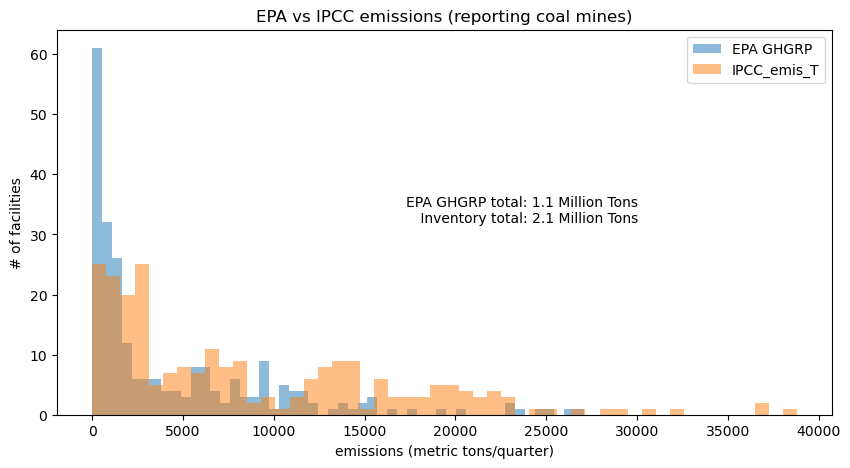

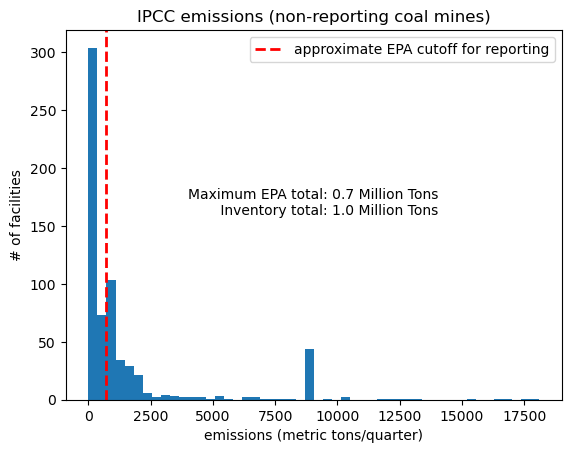

In [52]:
compare_hist(emission_comparison, 'epa_true_T', 'IPCC_emis_T', 'EPA vs IPCC emissions (reporting coal mines)')
plot_hist_nonreporting_coal_mines(emission_comparison, 'IPCC_emis_T', title='IPCC emissions (non-reporting coal mines)')
# error_metrics(x, y)

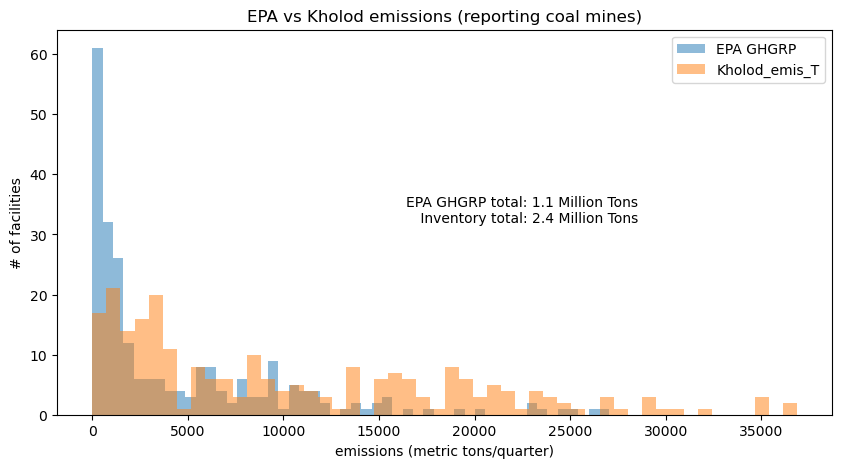

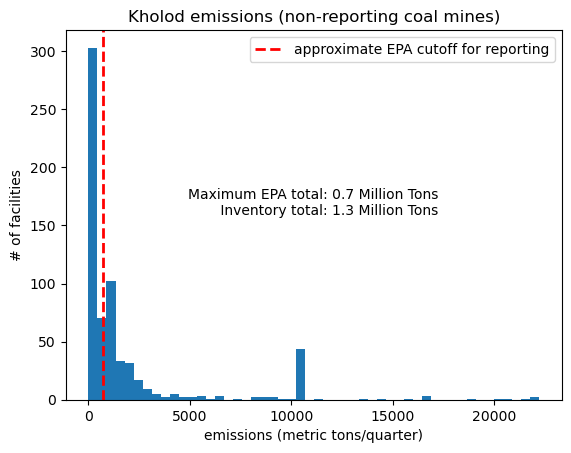

In [53]:
compare_hist(emission_comparison, 'epa_true_T', 'Kholod_emis_T', 'EPA vs Kholod emissions (reporting coal mines)')
plot_hist_nonreporting_coal_mines(emission_comparison, 'Kholod_emis_T', title='Kholod emissions (non-reporting coal mines)')
# error_metrics(x, y)

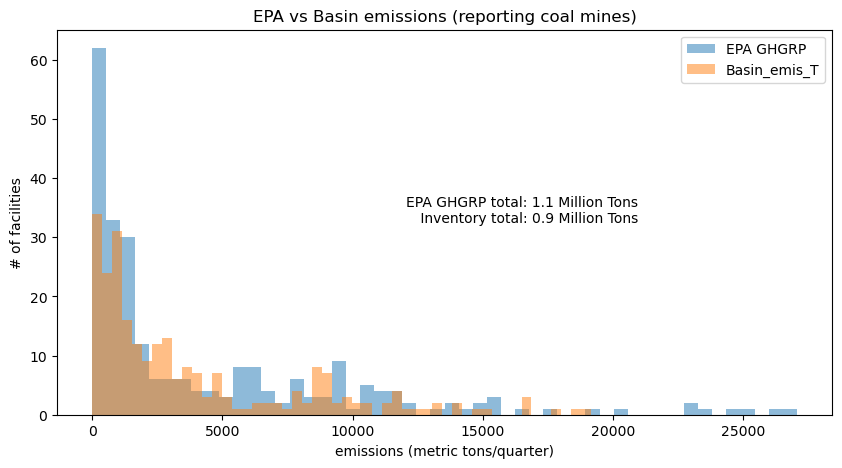

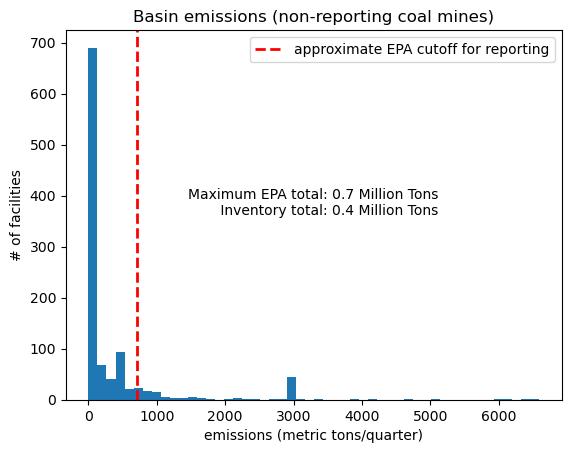

In [54]:
compare_hist(emission_comparison, 'epa_true_T', 'Basin_emis_T', 'EPA vs Basin emissions (reporting coal mines)')
plot_hist_nonreporting_coal_mines(emission_comparison, 'Basin_emis_T', title='Basin emissions (non-reporting coal mines)')
# error_metrics(x, y)

In [55]:
def plot_scatter(emission_comparison, x_col, y_col, title=''):
    plt.figure(dpi=200)
    plt.scatter(emission_comparison[x_col], emission_comparison[y_col], alpha=0.5)
    plt.plot(emission_comparison[x_col], emission_comparison[x_col], 'k', label='1:1')
    plt.xlabel(f'{x_col} (T)')
    plt.ylabel(f'{y_col} (T)')
    plt.legend()
    plt.xlim(0, 0.05*M_T_TO_T)
    plt.ylim(0, 0.05*M_T_TO_T)
    plt.title(title)
    x, y = emission_comparison.dropna(subset=[x_col, y_col])[x_col], emission_comparison.dropna(subset=[x_col, y_col])[y_col]
    plt.text(0.03*M_T_TO_T, 0.01*M_T_TO_T, 'Pearson R: {:.2f}'.format(pearsonr(x, y)[0]))
    plt.show()

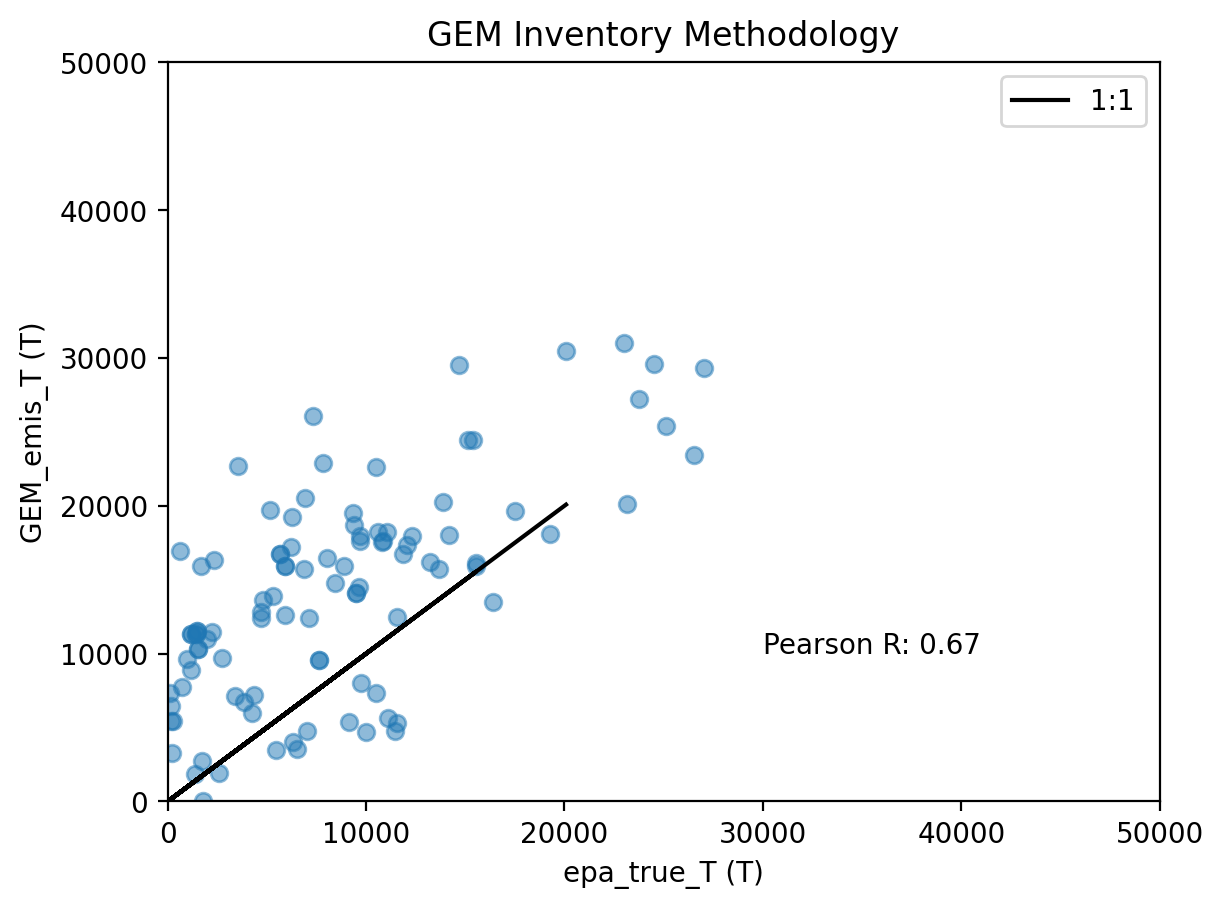

In [56]:
plot_scatter(emission_comparison, 'epa_true_T', 'GEM_emis_T', 'GEM Inventory Methodology')   

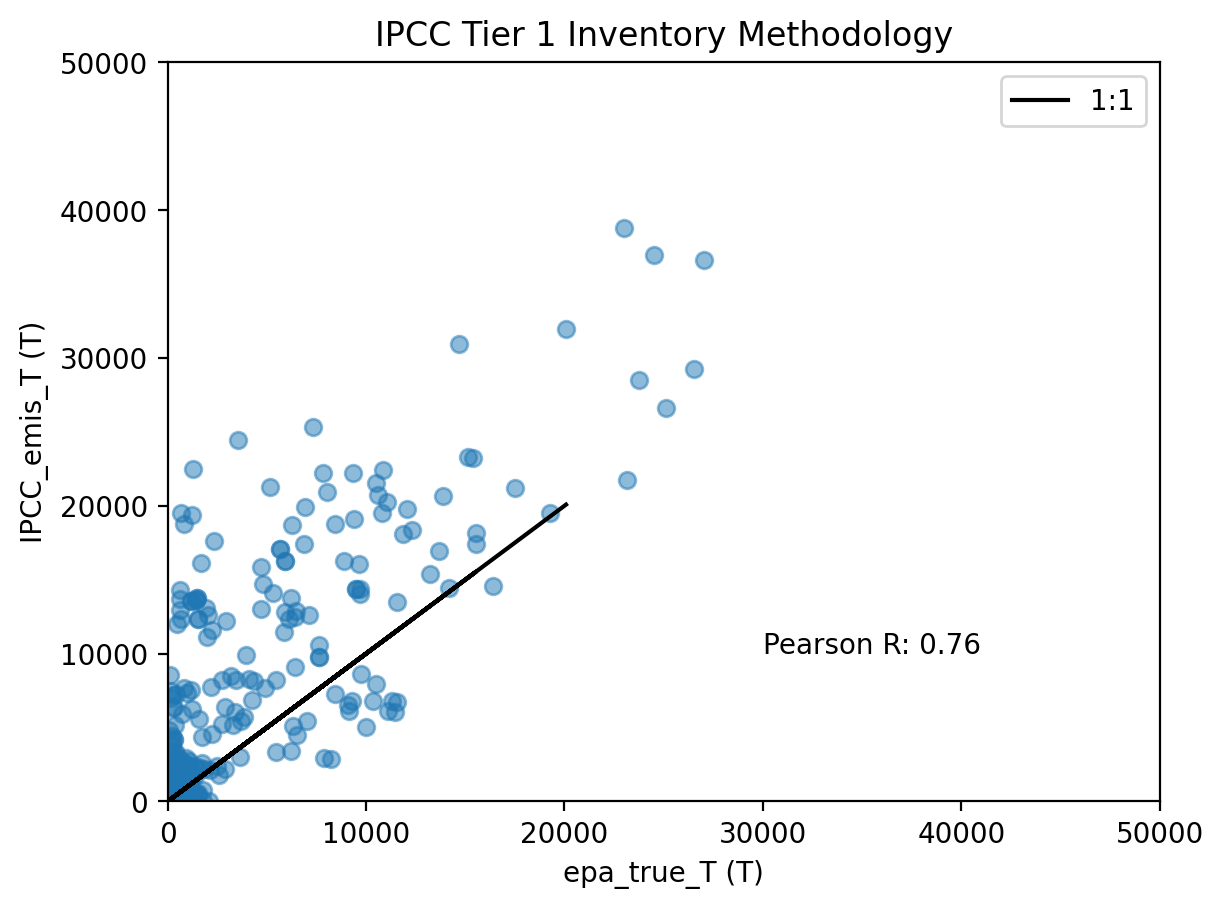

In [57]:
plot_scatter(emission_comparison, 'epa_true_T', 'IPCC_emis_T', 'IPCC Tier 1 Inventory Methodology')   

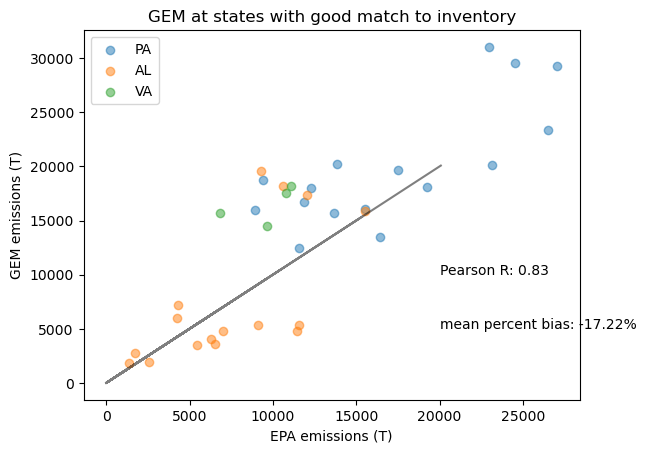

In [58]:
good_states = ['PA', 'AL', 'VA']
for state in good_states:
    plt.scatter(emission_comparison['epa_true_T'][emission_comparison['STATE'] == state], emission_comparison['GEM_emis_T'][emission_comparison['STATE'] == state], alpha=0.5, label=state)
plt.plot(emission_comparison['epa_true_T'][~emission_comparison['STATE'].isin(good_states)], emission_comparison['epa_true_T'][~emission_comparison['STATE'].isin(good_states)], alpha=0.5, color='k')
emission_comparison_nonan = emission_comparison.dropna(subset=['epa_true_T', 'GEM_emis_T'])
plt.text(0.02*M_T_TO_T, 0.01*M_T_TO_T, 'Pearson R: {:.2f}'.format(pearsonr(emission_comparison_nonan['epa_true_T'][emission_comparison_nonan['STATE'].isin(good_states)], 
                                                                           emission_comparison_nonan['GEM_emis_T'][emission_comparison_nonan['STATE'].isin(good_states)])[0]))
plt.text(0.02*M_T_TO_T, 0.005*M_T_TO_T, 'mean percent bias: {:.2f}%'.format(100*(emission_comparison_nonan['epa_true_T'][emission_comparison_nonan['STATE'].isin(good_states)] -
                                                                            emission_comparison_nonan['GEM_emis_T'][emission_comparison_nonan['STATE'].isin(good_states)]).mean()/
                                                                            emission_comparison_nonan['epa_true_T'][emission_comparison_nonan['STATE'].isin(good_states)].mean()))
plt.xlabel('EPA emissions (T)')
plt.ylabel('GEM emissions (T)')
plt.title('GEM at states with good match to inventory')
plt.legend()

/tmp/ipykernel_12672/1127151724.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(emission_comparison['epa_true_T'][emission_comparison['STATE'] == state], emission_comparison['GEM_emis_T'][emission_comparison['STATE'] == state], alpha=0.5, label=state, c=cmap(i))
/tmp/ipykernel_12672/1127151724.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(emission_comparison['epa_true_T'][emission_comparison

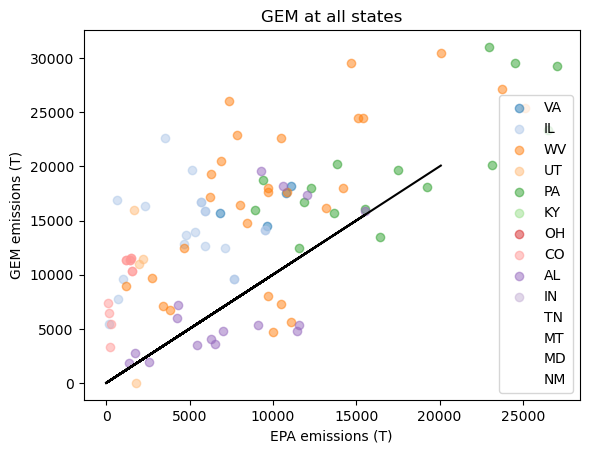

,State,Mean Percent Bias,Mean Bias,RMSPE
0,VA,70.3,6894.3,71.1
1,IL,292.2,8883.5,180.3
2,WV,180.9,6742.0,147.9
3,UT,399.0,7666.7,219.9
4,PA,30.1,2756.3,50.1
5,KY,NaN,NaN,NaN
6,OH,NaN,NaN,NaN
7,CO,1115.9,8298.1,315.3
8,AL,2.3,171.2,52.2
9,IN,NaN,NaN,NaN


In [59]:
metrics_df = pd.DataFrame(columns=['State', 'Mean Percent Bias', 'Mean Bias', 'RMSPE'])
cmap = plt.get_cmap('tab20')
i = 0
for state in emission_comparison['STATE'].unique():
    mean_percent_bias = 100 * (emission_comparison["GEM_emis_T"][emission_comparison["STATE"] == state] - emission_comparison["epa_true_T"][emission_comparison["STATE"] == state]).mean() / emission_comparison["epa_true_T"][emission_comparison["STATE"] == state].mean()
    rmspe = np.sqrt(np.mean((emission_comparison["GEM_emis_T"][emission_comparison["STATE"] == state] - emission_comparison["epa_true_T"][emission_comparison["STATE"] == state]) ** 2) / emission_comparison["epa_true_T"][emission_comparison["STATE"] == state].mean())
    mean_bias = (emission_comparison["GEM_emis_T"][emission_comparison["STATE"] == state] - emission_comparison["epa_true_T"][emission_comparison["STATE"] == state]).mean()
    metrics_df = metrics_df._append({'State': state, 'Mean Percent Bias': mean_percent_bias, 'Mean Bias': mean_bias, 'RMSPE': rmspe, }, ignore_index=True)
    plt.scatter(emission_comparison['epa_true_T'][emission_comparison['STATE'] == state], emission_comparison['GEM_emis_T'][emission_comparison['STATE'] == state], alpha=0.5, label=state, c=cmap(i))
    i += 1

plt.plot(emission_comparison['epa_true_T'], emission_comparison['epa_true_T'], color='k')
plt.xlabel('EPA emissions (T)')
plt.ylabel('GEM emissions (T)')
plt.legend()
plt.title('GEM at all states')
plt.show()

metrics_df.round(1)


IL, CO, UT, IN.... all the 0s that are overestimated

A FEW GASSY IL MINES - shallower


WV overestimated 


PA good. 

In [60]:
def error_metrics(x,y):
    print(f"mean emissions: {np.mean(x):0.2f} T")
    print(f"stdev emissions: {np.std(x):0.2f} T")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(x, y)):0.2f} T")
    print(f"Coefficient of determination: {metrics.r2_score(x, y):0.2f}")
    print(f"MAE: {metrics.mean_absolute_error(x, y):0.2f}")
    print(f"MAPE: {100*np.mean(np.abs(x-y)[x>0]/x[x>0]):0.2f}%")
    print(f"total emissions difference: {(np.sum(y)-np.sum(x))/np.sum(x)*100:0.2f}%")